# Quickstart Example of Advanced Off-Policy Evaluation and Selection (Discrete)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a basic synthetic dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [4]:
# import SCOPE-RL modules
import scope_rl
from basicgym import BasicEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead
from scope_rl.policy import EpsilonGreedyHead
from scope_rl.policy import SoftmaxHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy as RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler
from scope_rl.utils import MinMaxScaler


# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(scope_rl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [ ]:
# ignore warnings
import warnings
warnings.simplefilter('ignore')

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe the basic usage of the environment.

#### RL setup for Basic Synthetic
In Basic Synthetic, the objective of the RL agent is to maximize reward.

We often formulate this synthetic  problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: State observation, which may be noisy in POMDPs.
- `action`:  Indicating the action to presented by the RL agent.
- `reward`: Reward observation.

For more about the environmental configuration and its customization, please refer to [examples/quickstart/basic/basic_synthetic_customize_env.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_customize_env.ipynb).

In [9]:
# standardized environment for discrete action
env = gym.make("BasicEnv-discrete-v0")

In [10]:
# for api compatibility to d3rlpy
from scope_rl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: Basic environment for RL defined in the previous section.
- `max_episode_steps`: Maximum number of timesteps in an episode.

For more about the data collection and visualization, please refer to [examples/quickstart/basic/basic_synthetic_data_collection.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_data_collection.ipynb).

In [11]:
# behavior policy
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [ ]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env_,
    buffer,
    explorer=explorer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [ ]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [12]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

In [13]:
behavior_policy_01 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.1,
    name="ddqn_eps_0.1",
    random_state=random_state,
)
behavior_policy_03 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_eps_0.3",
    random_state=random_state,
)
behavior_policy_05 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.5,
    name="ddqn_eps_0.5",
    random_state=random_state,
)
behavior_policy_07 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.7,
    name="ddqn_eps_0.7",
    random_state=random_state,
)
behavior_policies = [behavior_policy_01, behavior_policy_03, behavior_policy_05, behavior_policy_07]

In [14]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [ ]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    n_datasets=5, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    n_datasets=5, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

In [16]:
with open("logs/train_dataset_discrete_ddqn_multi.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddqn_multi.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [17]:
with open("logs/train_dataset_discrete_ddqn_multi.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddqn_multi.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/basic/basic_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/scope_rl/blob/ope/examples/quickstart/basic/basic_synthetic_discrete_basic.ipynb).

In [18]:
# import modules
from scope_rl.policy import TrainCandidatePolicies
# import models from d3rlpy
from d3rlpy.algos import DiscreteCQL as CQL

In [19]:
# evaluation policies
cql_b1 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)
cql_b2 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)
cql_b3 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

algorithms = [cql_b1, cql_b2, cql_b3]
algorithms_name = ["cql_b1", "cql_b2", "cql_b3"]

In [20]:
# initialize OPL class
opl = TrainCandidatePolicies(
    fitting_args={
        "n_steps": 10000,
        "scorers": {},
    }
)

In [ ]:
# obtain base policies
base_policies = opl.learn_base_policy(
    logged_dataset=train_logged_dataset,
    algorithms=algorithms,
    random_state=random_state,
)

In [22]:
with open("d3rlpy_logs/multiple_discrete_base_policies.pkl", "wb") as f:
    pickle.dump(base_policies, f)

In [23]:
with open("d3rlpy_logs/multiple_discrete_base_policies.pkl", "rb") as f:
    base_policies = pickle.load(f)

In [24]:
# policy wrapper
policy_wrappers = {
    "eps_00": (
        EpsilonGreedyHead, {
            "epsilon": 0.0,
            "n_actions": env.action_space.n,
        }
    ),
    "eps_03": (
        EpsilonGreedyHead, {
            "epsilon": 0.3,
            "n_actions": env.action_space.n,
        }
    ),
    "eps_07": (
        EpsilonGreedyHead, {
            "epsilon": 0.7,
            "n_actions": env.action_space.n,
        }
    ),
    "softmax": (
        SoftmaxHead, {
            "tau": 1.0,
            "n_actions": env.action_space.n,
        }
    )
}

In [25]:
eval_policies = opl.apply_head(
    base_policies=base_policies,
    base_policies_name=algorithms_name,
    policy_wrappers=policy_wrappers,
    random_state=random_state,
)

In [26]:
[eval_policy.name for eval_policy in eval_policies[behavior_policies[0].name][0]]

['cql_b1_eps_00',
 'cql_b1_eps_03',
 'cql_b1_eps_07',
 'cql_b1_softmax',
 'cql_b2_eps_00',
 'cql_b2_eps_03',
 'cql_b2_eps_07',
 'cql_b2_softmax',
 'cql_b3_eps_00',
 'cql_b3_eps_03',
 'cql_b3_eps_07',
 'cql_b3_softmax']

## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

### Preparation: Create OPE Input

First, we obtain input dictionary using the CreateOPEInput class.

In [27]:
# import ope modules from SCOPE-RL
from scope_rl.ope import CreateOPEInput

In [28]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].min(axis=0),
        maximum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].max(axis=0),
    ),
)

In [ ]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=eval_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [30]:
with open("logs/ope_input_dict_discrete_multiple_datasets.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [31]:
with open("logs/ope_input_dict_discrete_multiple_datasets.pkl", "rb") as f:
    input_dict = pickle.load(f)

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [32]:
# import ope modules from SCOPE-RL
from scope_rl.ope import OffPolicyEvaluation as BasicOPE
from scope_rl.ope.discrete import DirectMethod as DM
from scope_rl.ope.discrete import TrajectoryWiseImportanceSampling as TIS
from scope_rl.ope.discrete import PerDecisionImportanceSampling as PDIS
from scope_rl.ope.discrete import DoublyRobust as DR
from scope_rl.ope.discrete import SelfNormalizedTIS as SNTIS
from scope_rl.ope.discrete import SelfNormalizedPDIS as SNPDIS
from scope_rl.ope.discrete import SelfNormalizedDR as SNDR

In [33]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [34]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict["ddqn_eps_0.3"][0]

{'cql_b1_eps_00':            policy_value  relative_policy_value
 on_policy      9.455767               1.000000
 dm            81.120504               8.578945
 tis            8.329709               0.880913
 pdis           8.189470               0.866082
 dr             9.518302               1.006613
 sntis          8.469552               0.895702
 snpdis         8.440106               0.892588
 sndr           8.394941               0.887812,
 'cql_b1_eps_03':            policy_value  relative_policy_value
 on_policy      6.917596               1.000000
 dm            78.044044              11.281960
 tis            5.981859               0.864731
 pdis           6.003803               0.867903
 dr             7.969903               1.152120
 sntis          6.147756               0.888713
 snpdis         6.130161               0.886169
 sndr           5.995271               0.866670,
 'cql_b1_eps_07':            policy_value  relative_policy_value
 on_policy      3.672857           

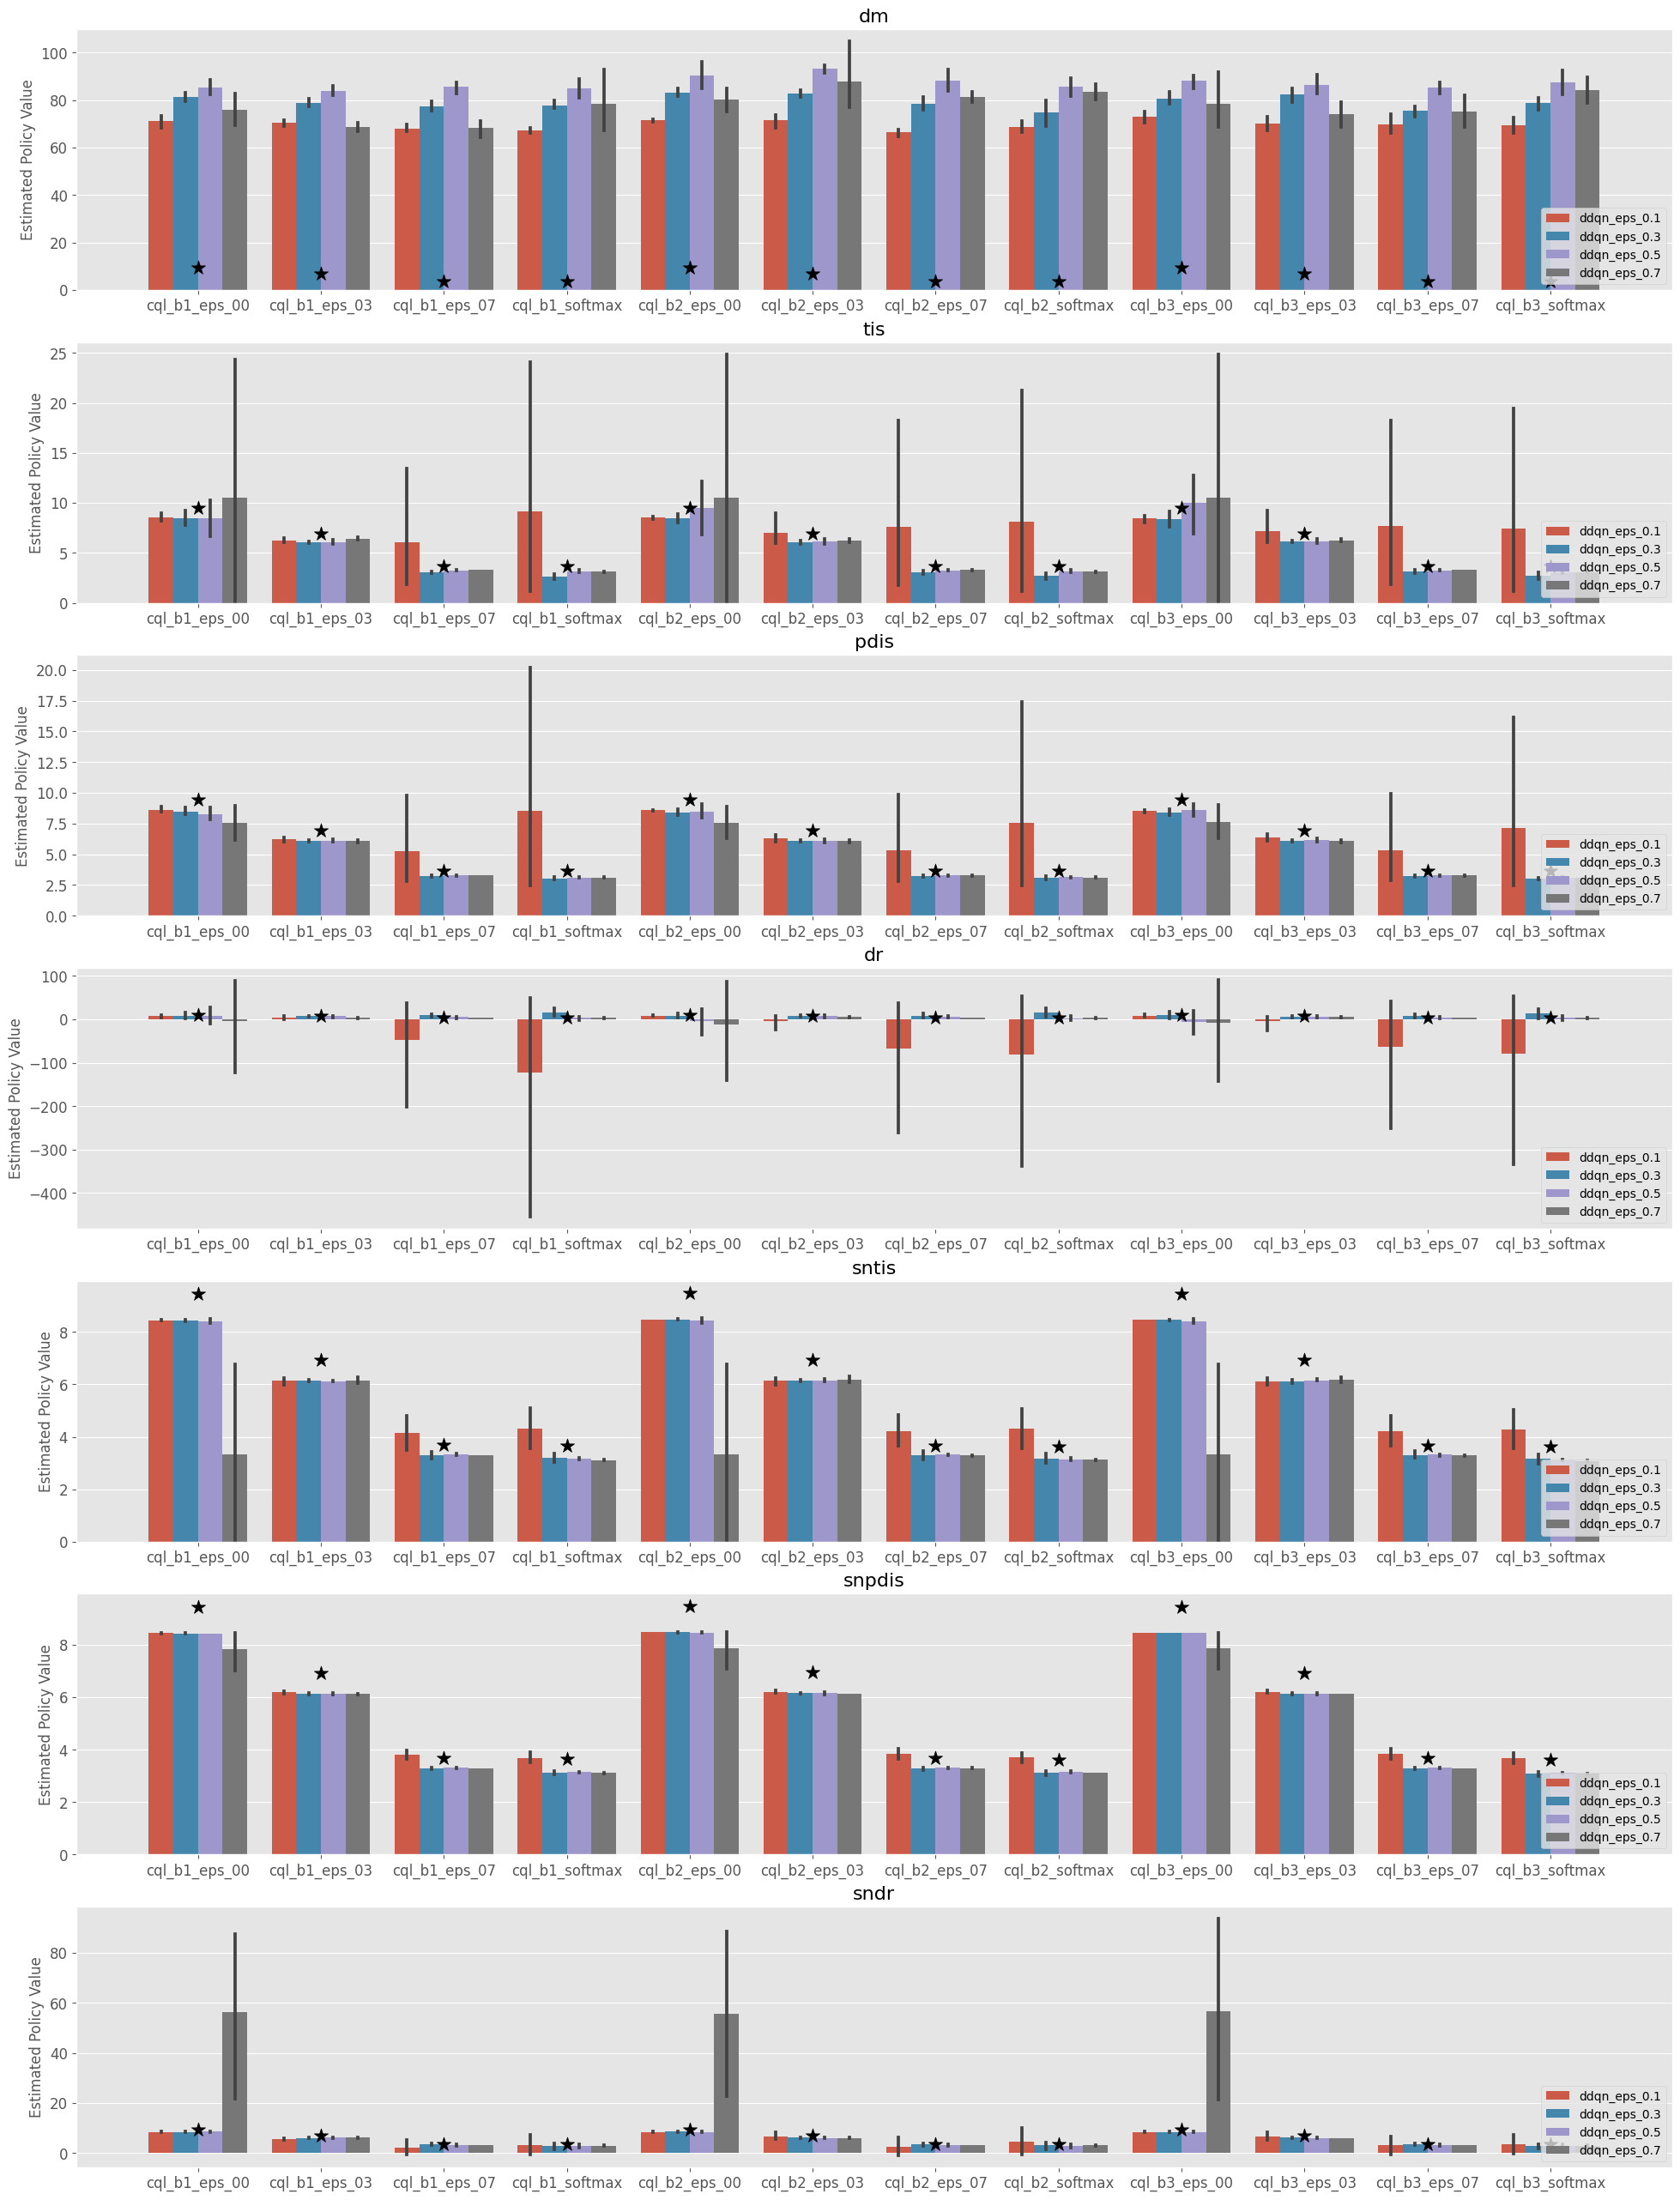

In [35]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

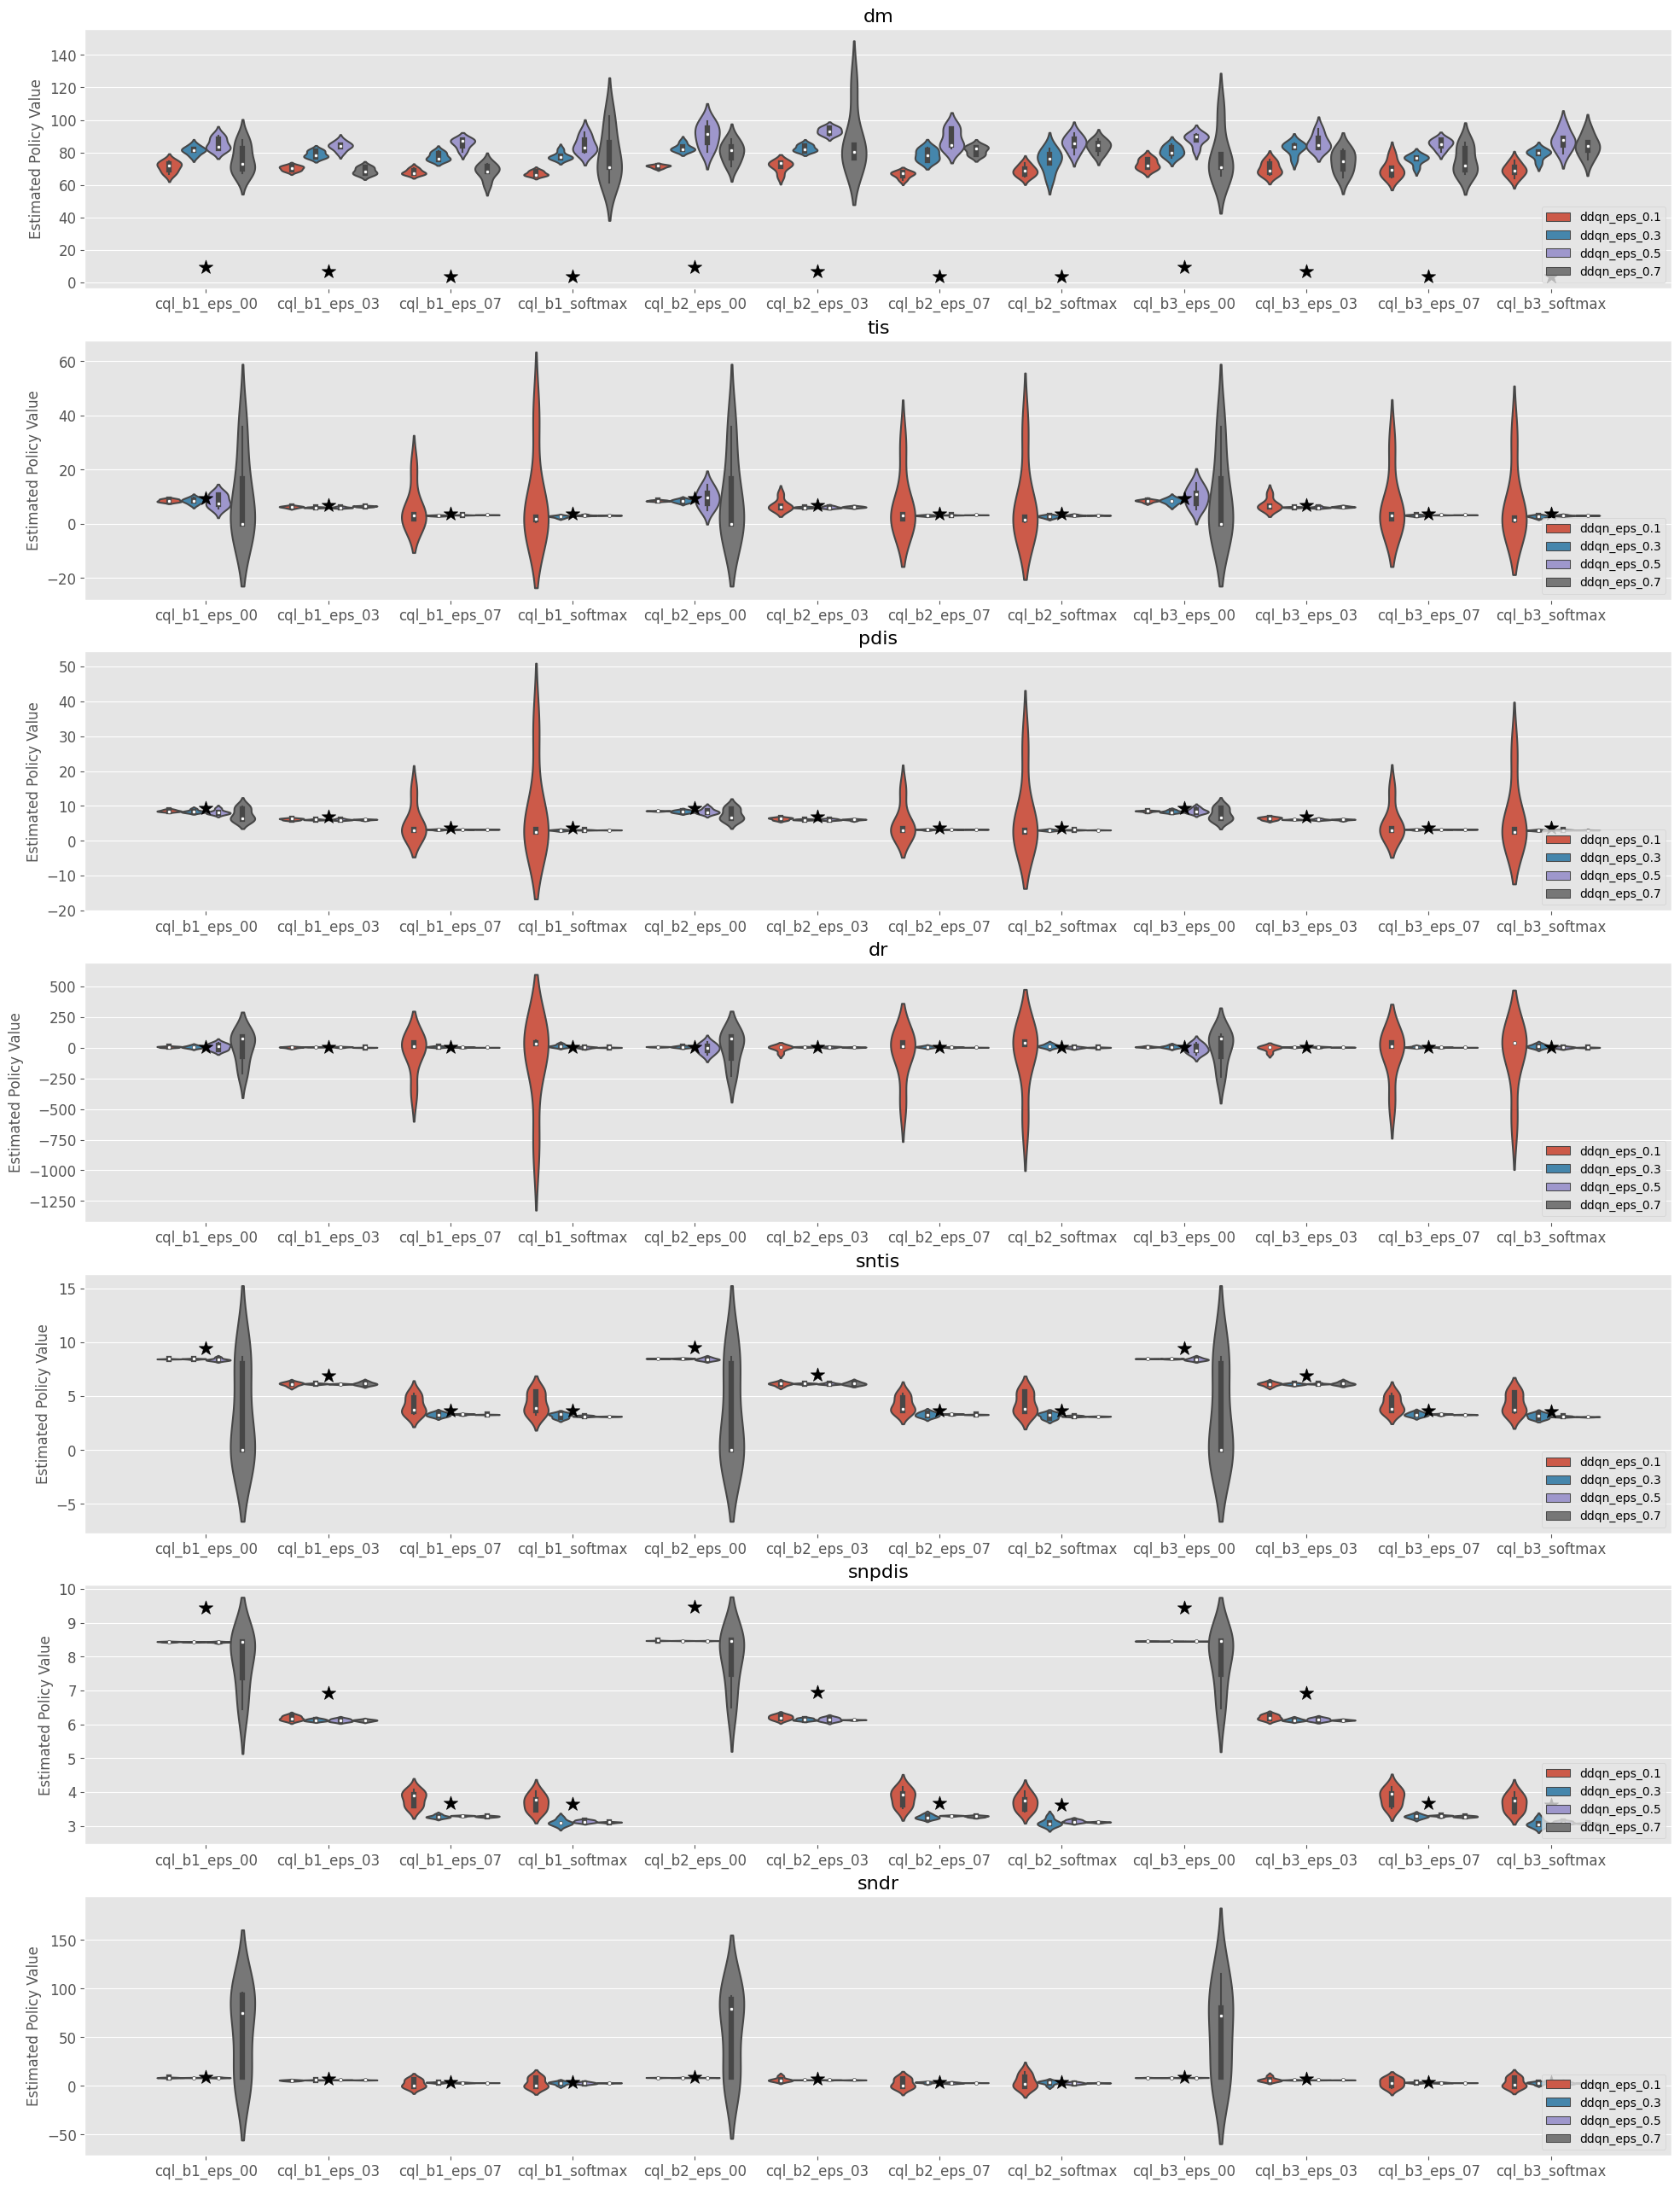

In [36]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
)

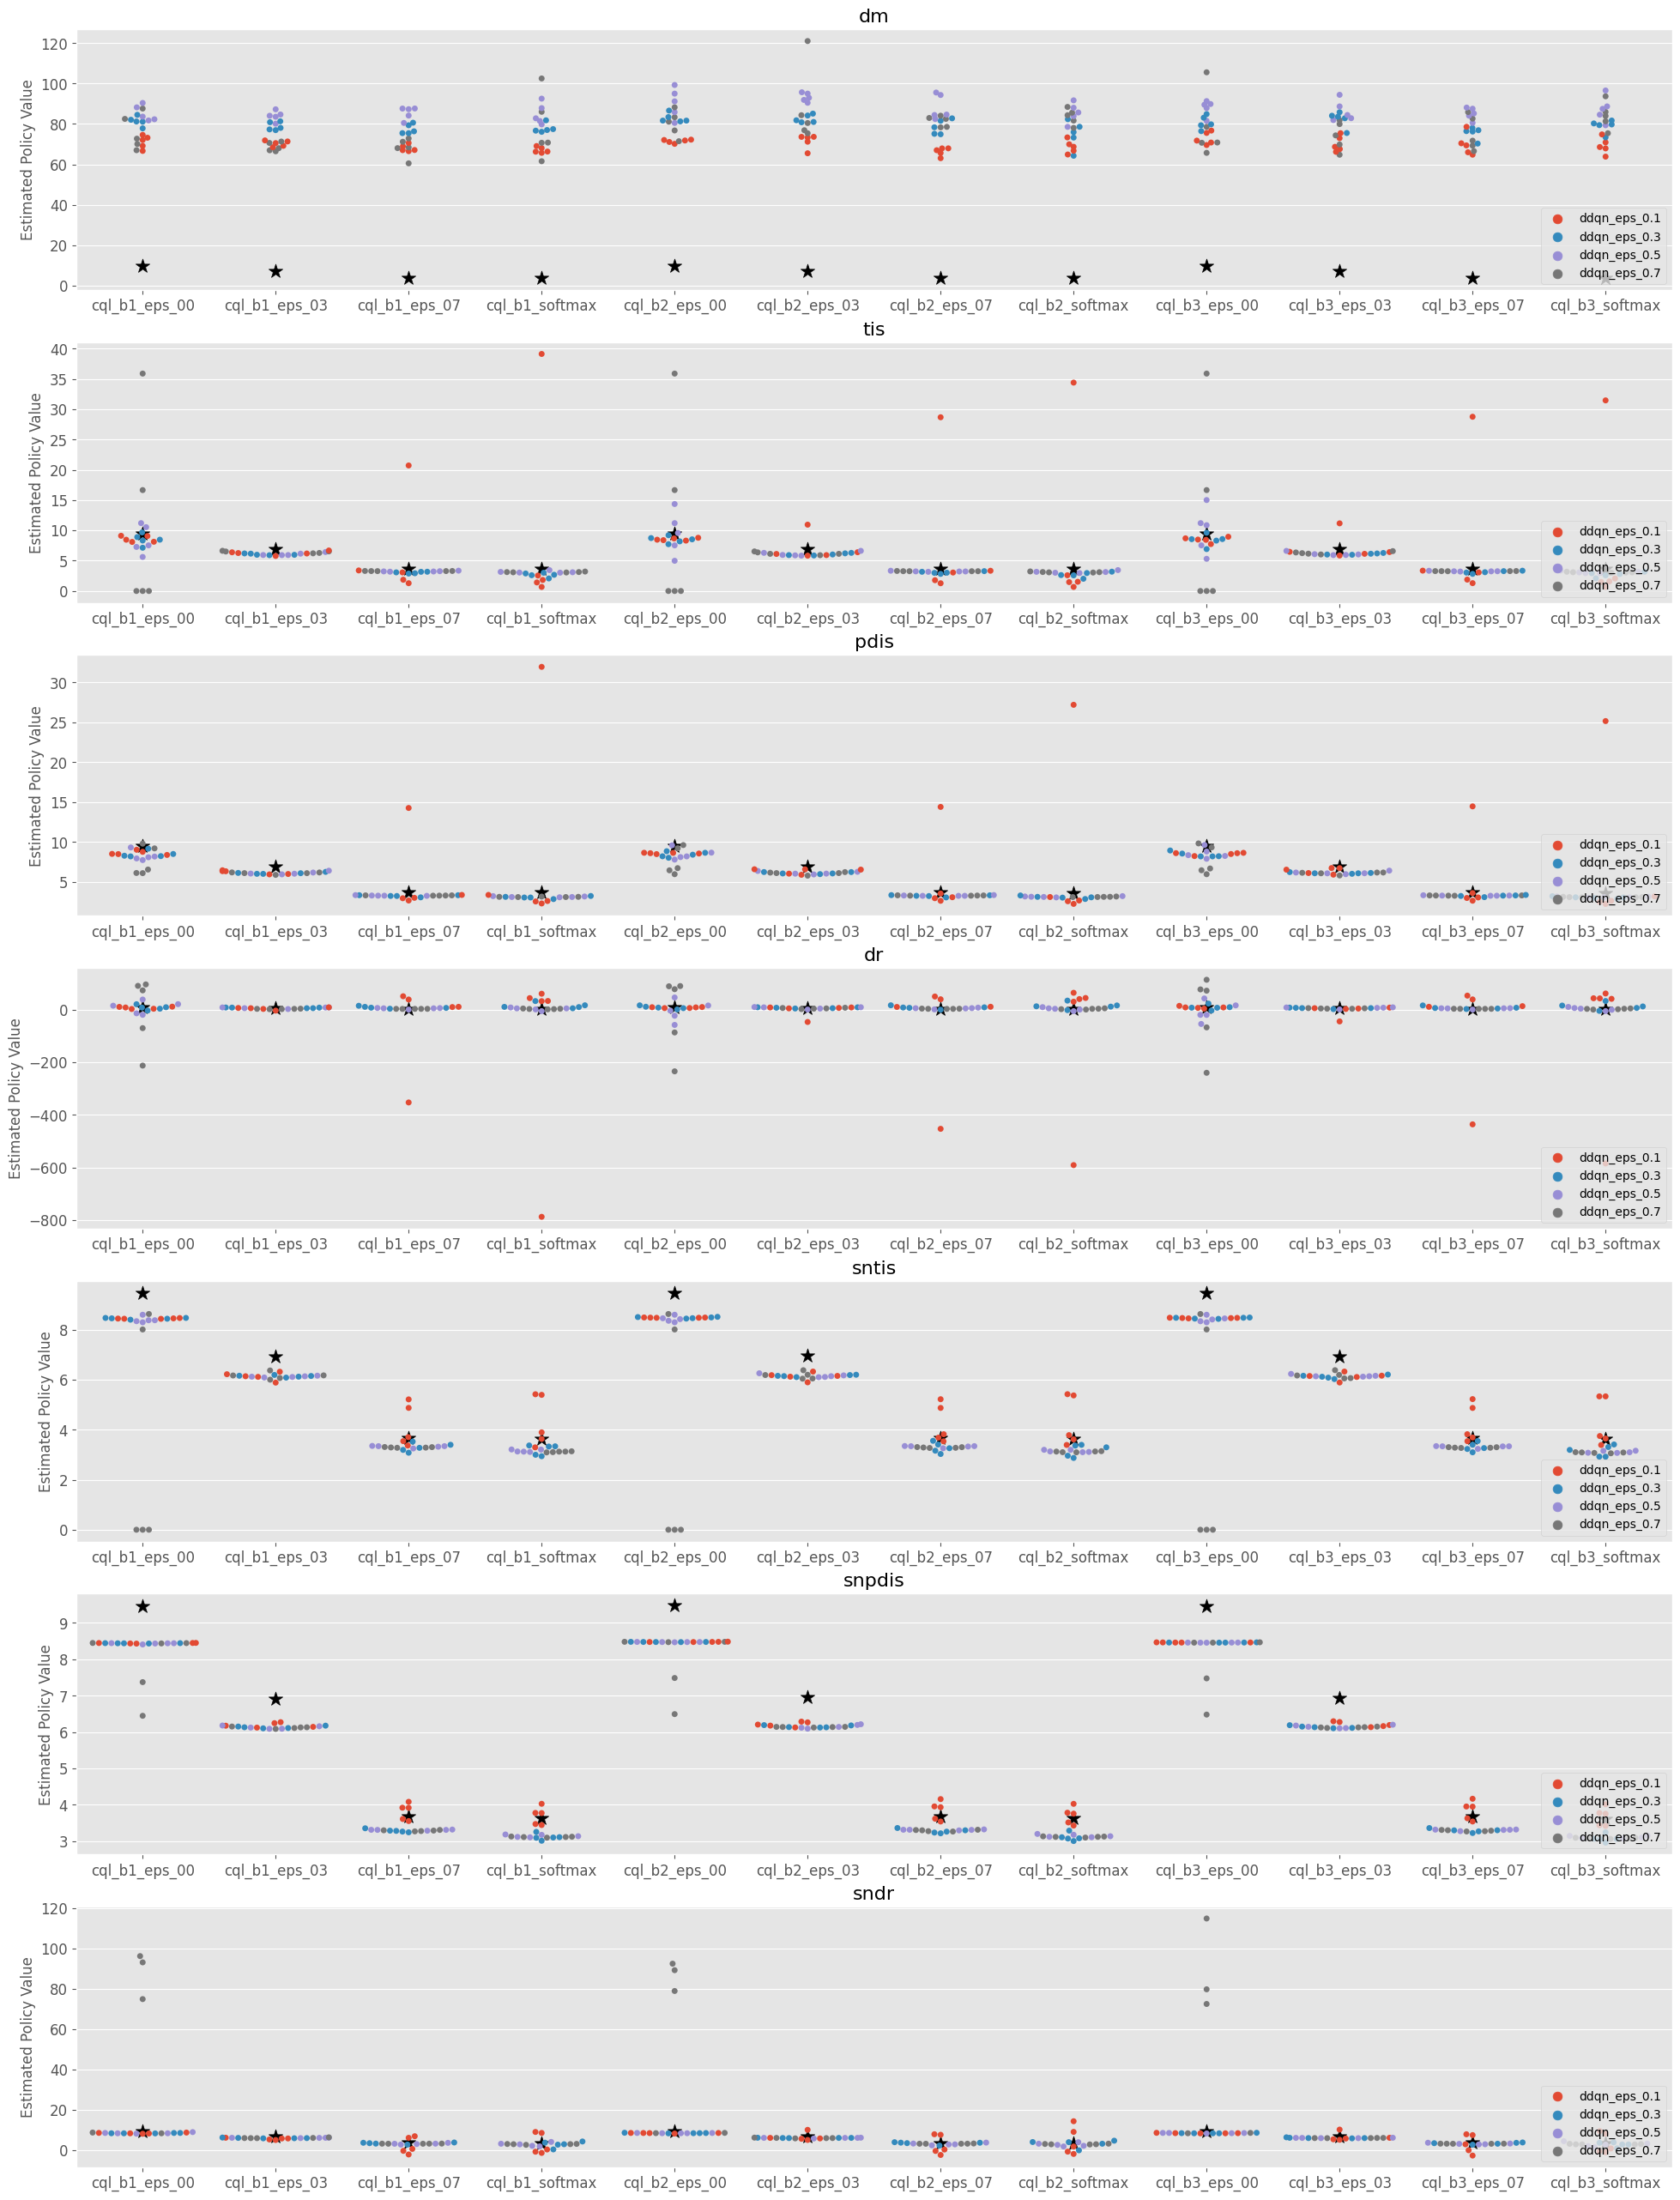

In [37]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="scatter",
    hue="policy",
)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [38]:
from scope_rl.ope import CumulativeDistributionOPE
from scope_rl.ope.discrete import CumulativeDistributionDM as CD_DM
from scope_rl.ope.discrete import CumulativeDistributionTIS as CD_IS
from scope_rl.ope.discrete import CumulativeDistributionTDR as CD_DR
from scope_rl.ope.discrete import CumulativeDistributionSNTIS as CD_SNIS
from scope_rl.ope.discrete import CumulativeDistributionSNTDR as CD_SNDR

In [39]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

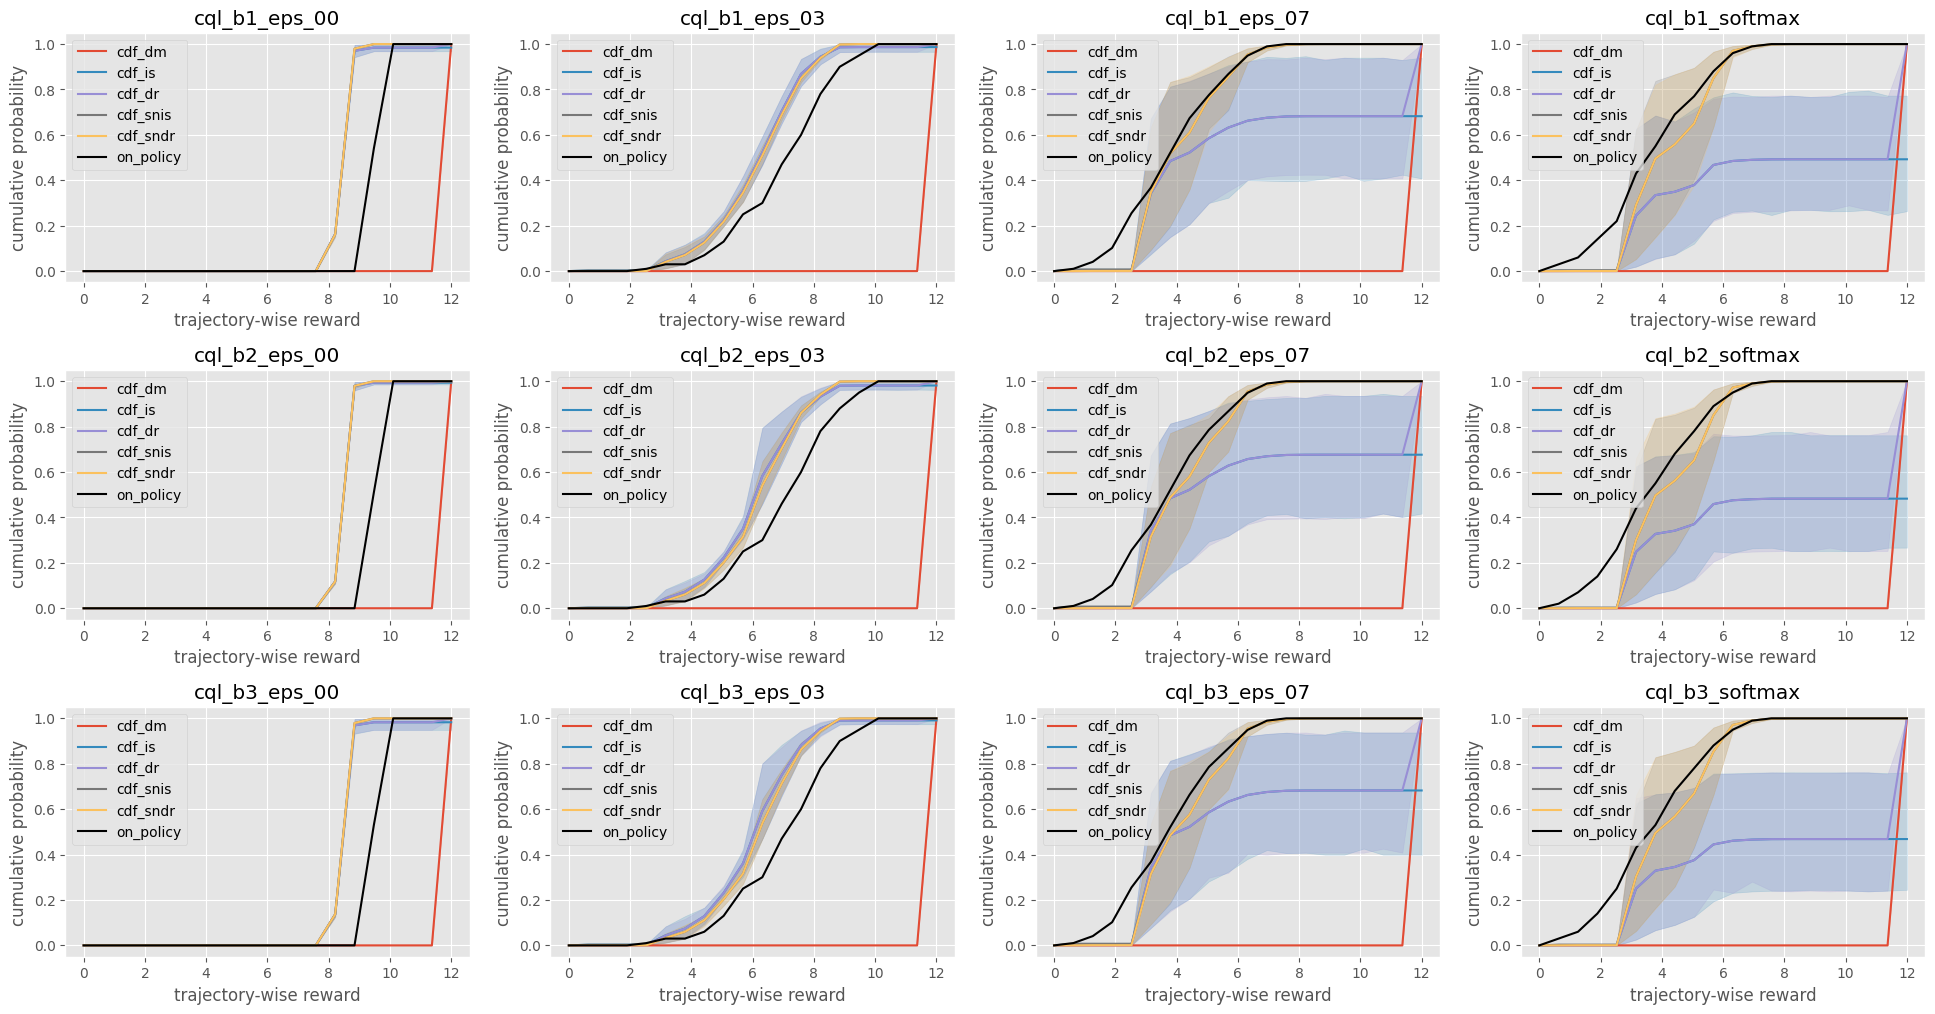

In [40]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="ddqn_eps_0.1",
    plot_type="ci_hue",
    scale_min=0.0, 
    scale_max=12.0, 
    n_partition=20, 
    n_cols=4,
)

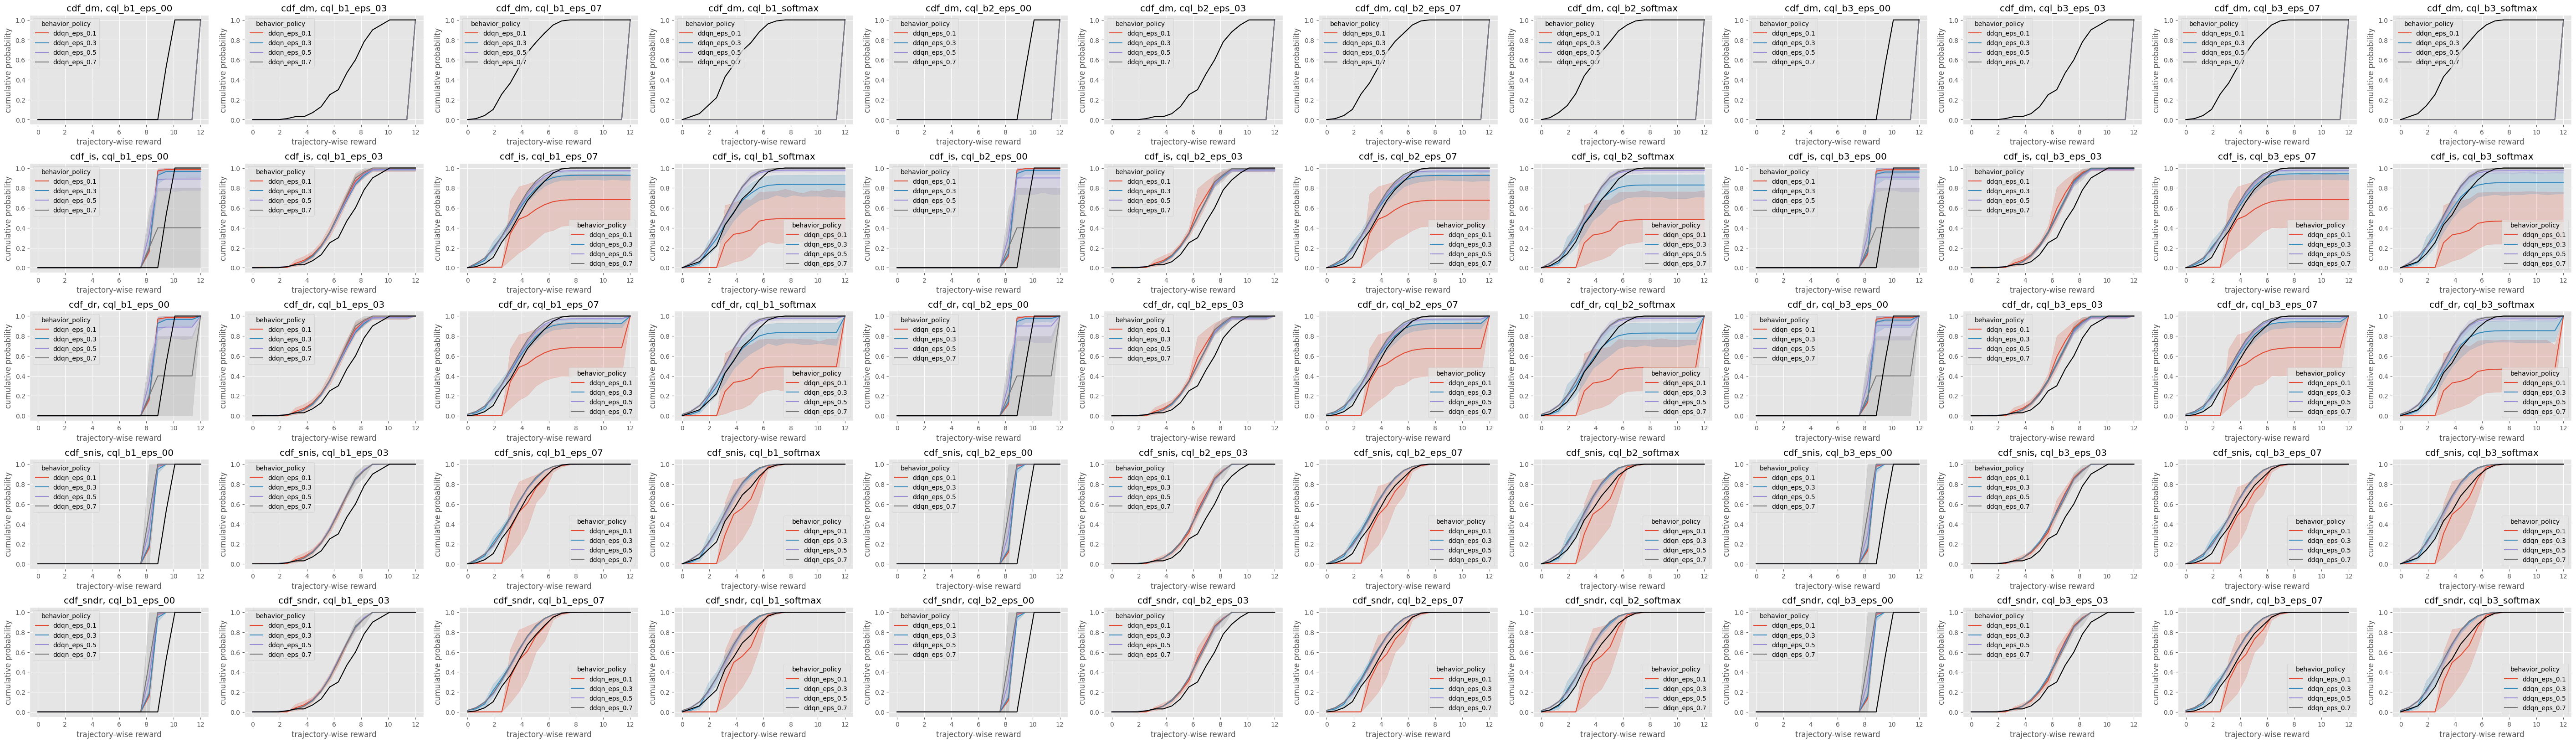

In [41]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    plot_type="ci_behavior_policy",
    hue="policy",
    scale_min=0.0, 
    scale_max=12.0, 
    n_partition=20, 
)

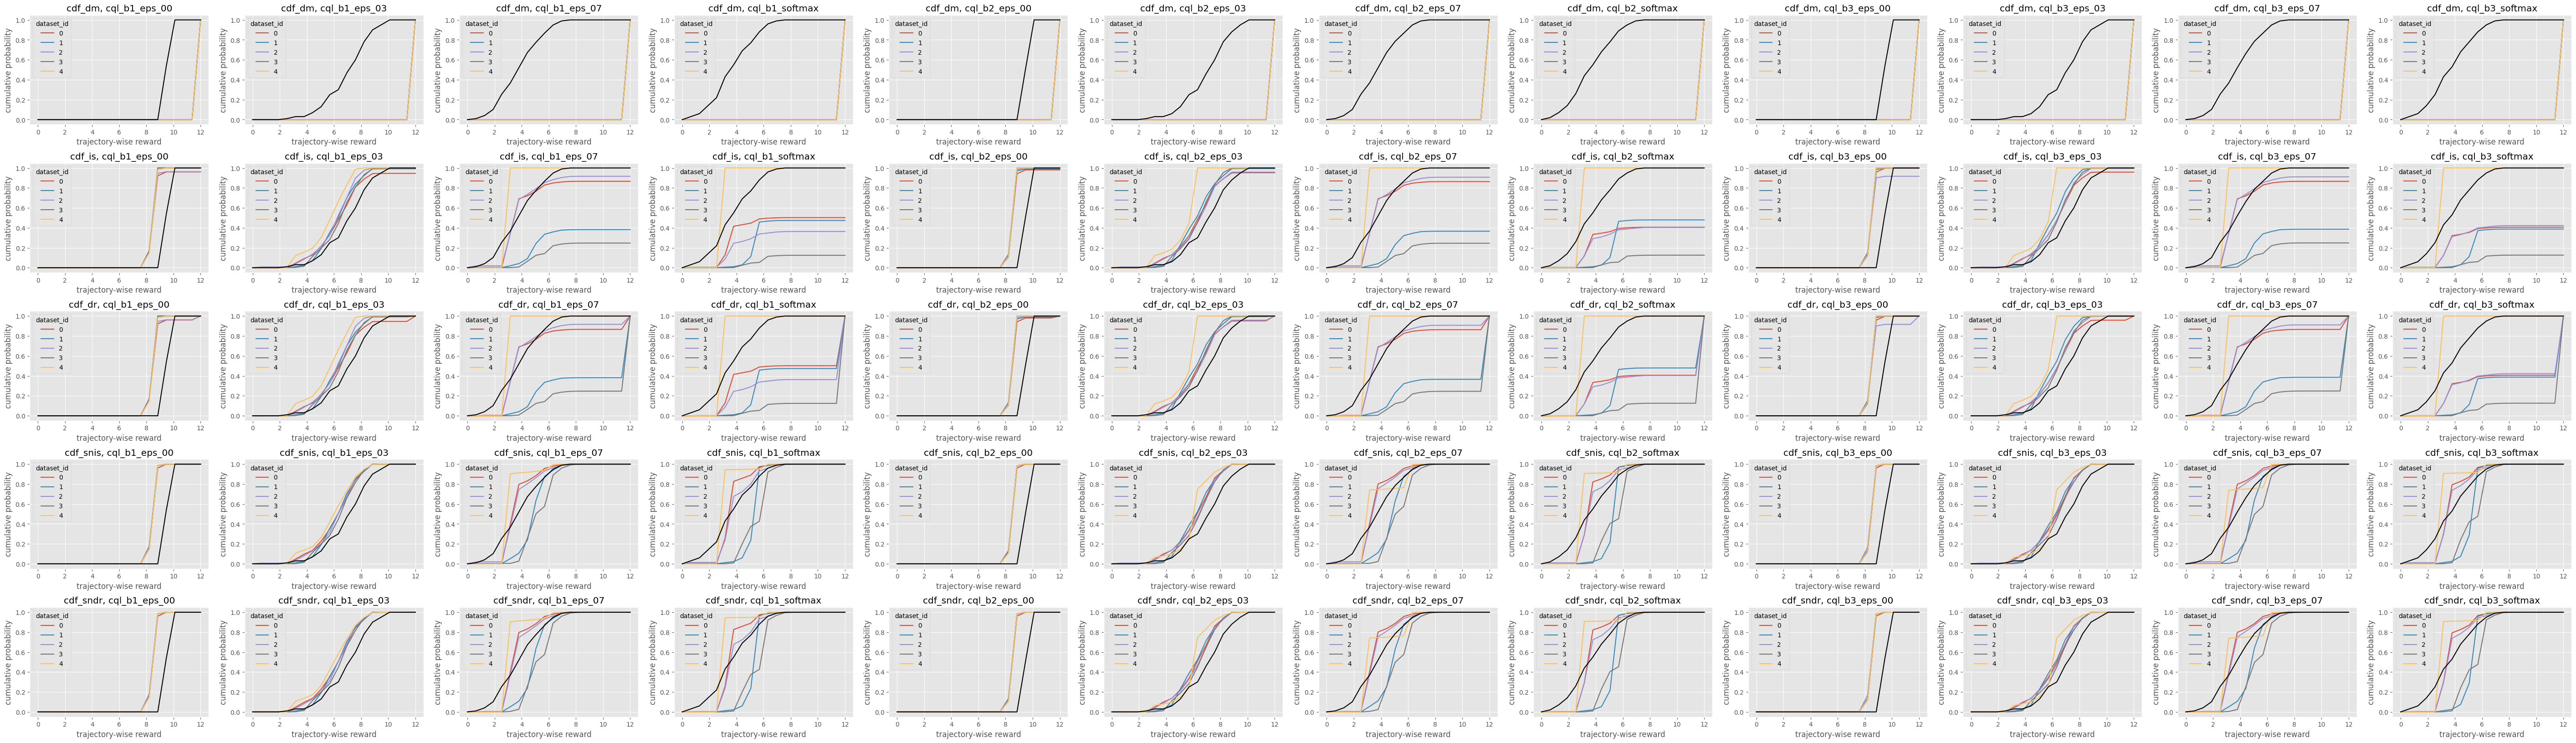

In [42]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="ddqn_eps_0.1",
    plot_type="enumerate",
    hue="policy",
    scale_min=0.0, 
    scale_max=12.0, 
    n_partition=20, 
)

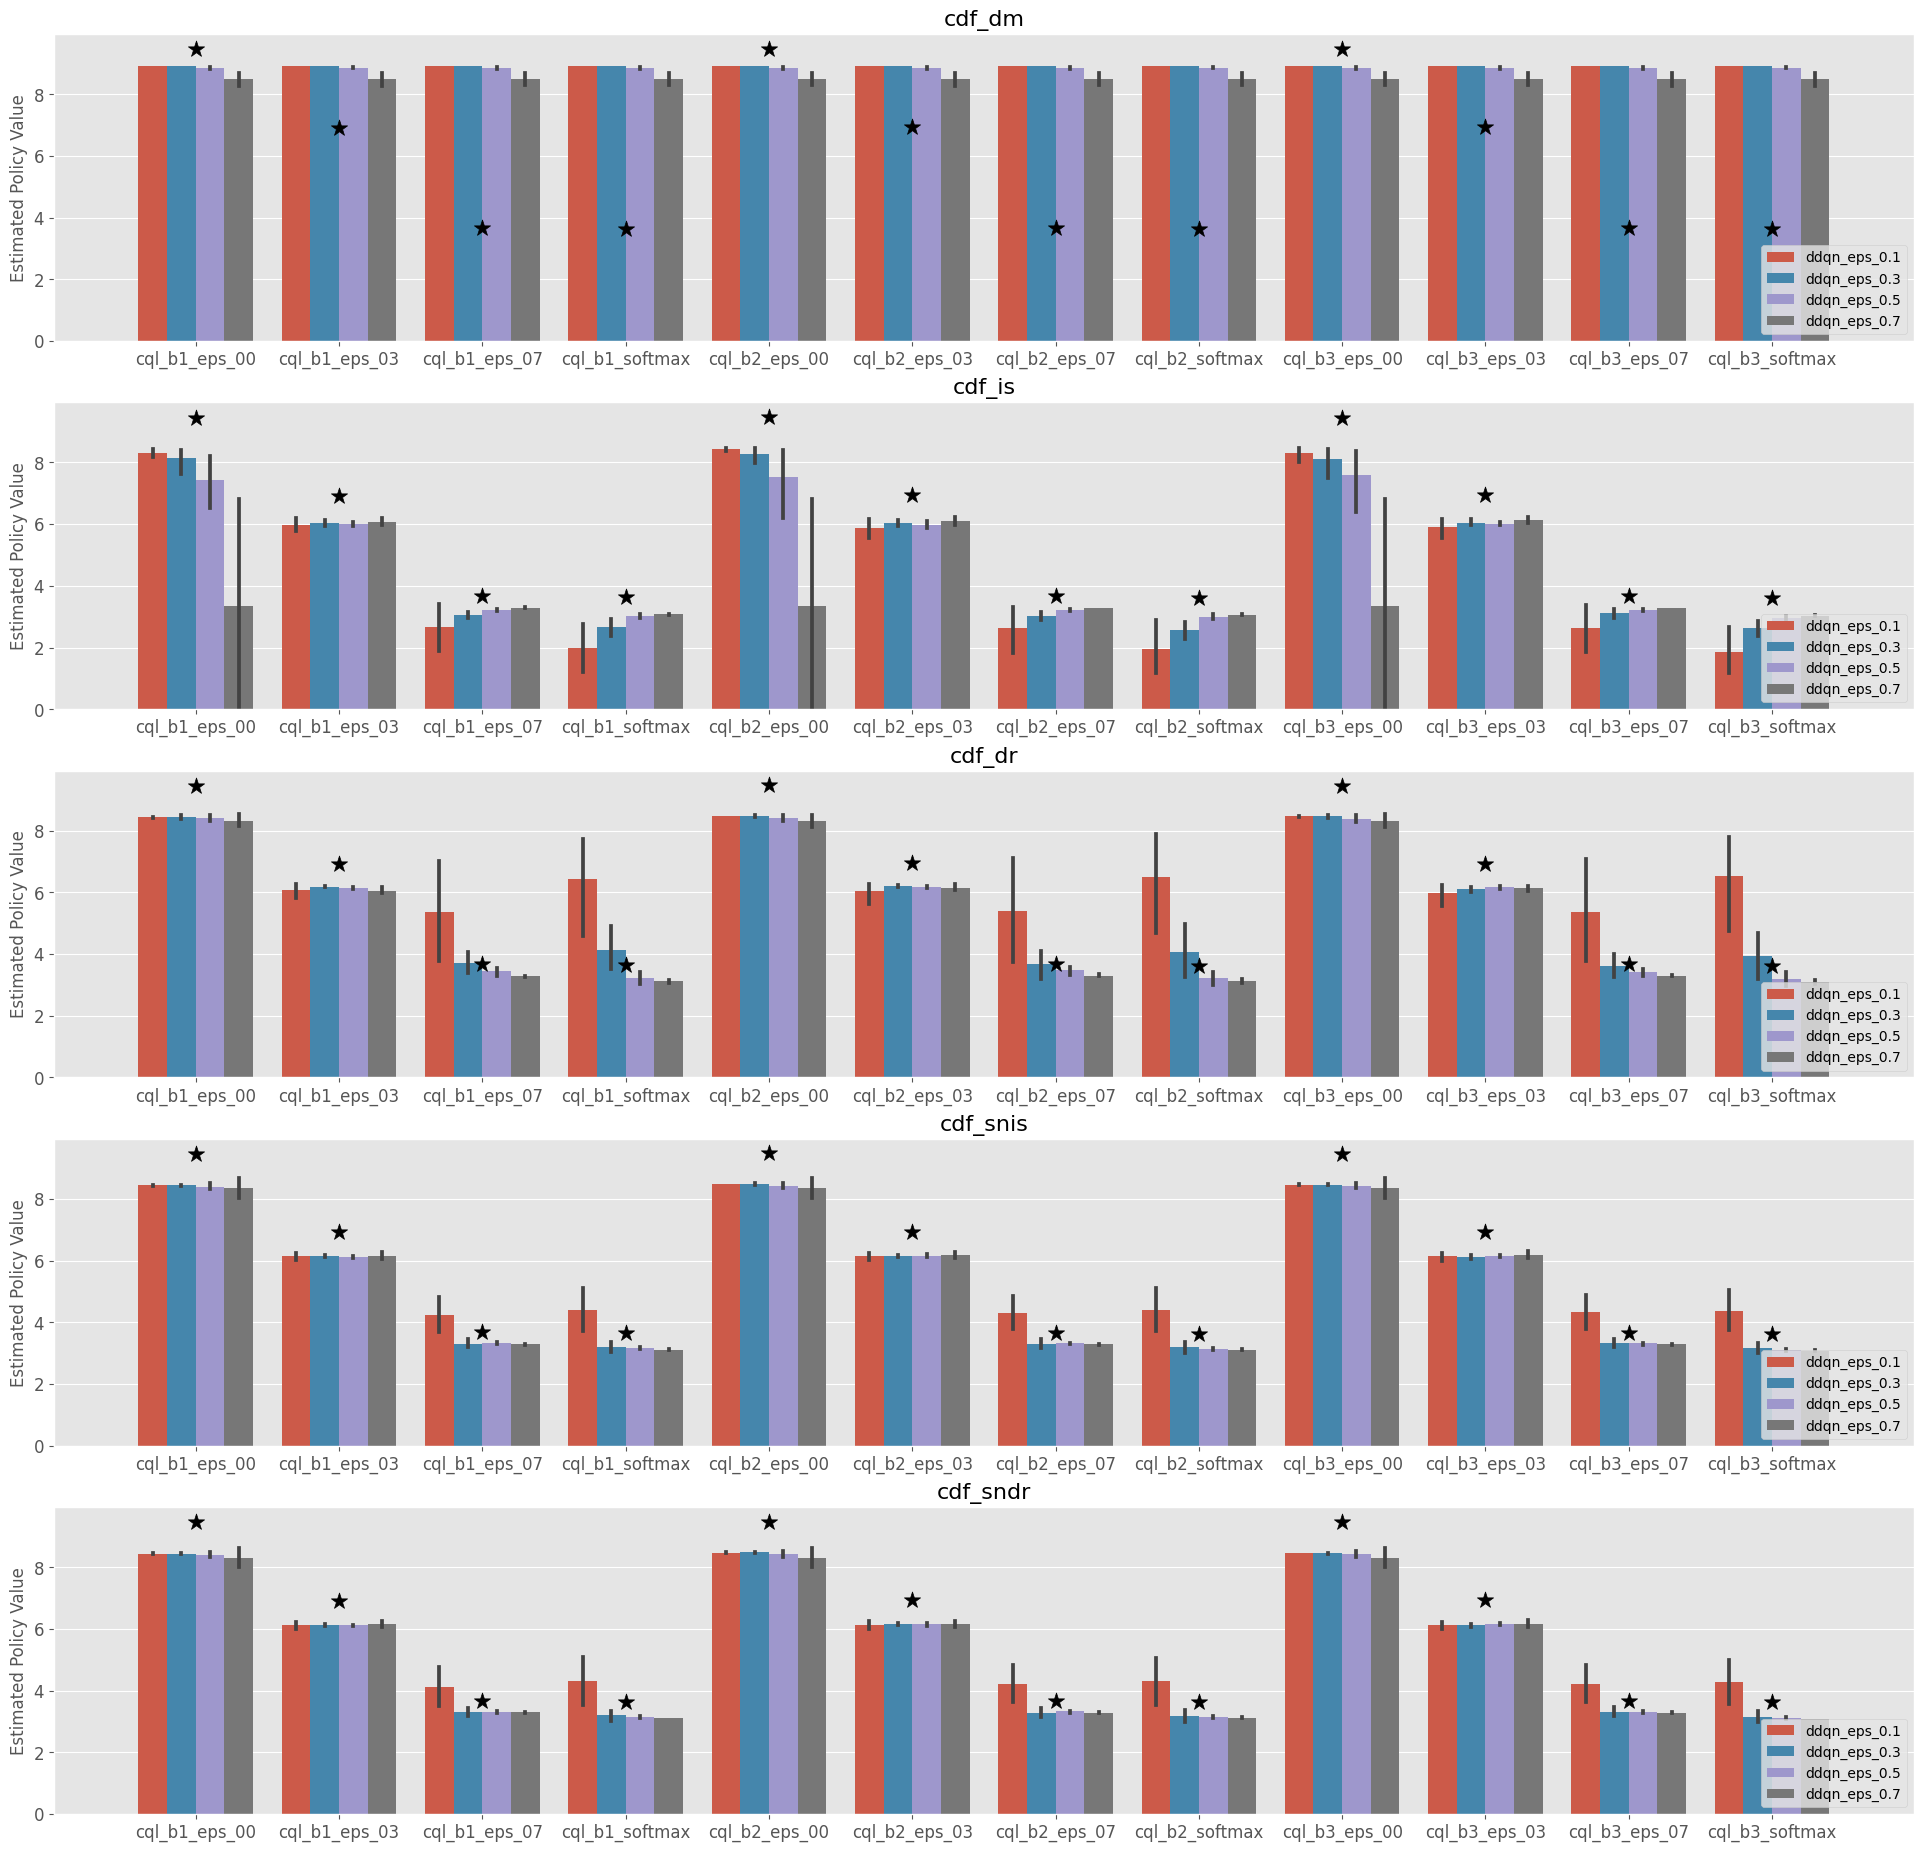

In [43]:
cd_ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

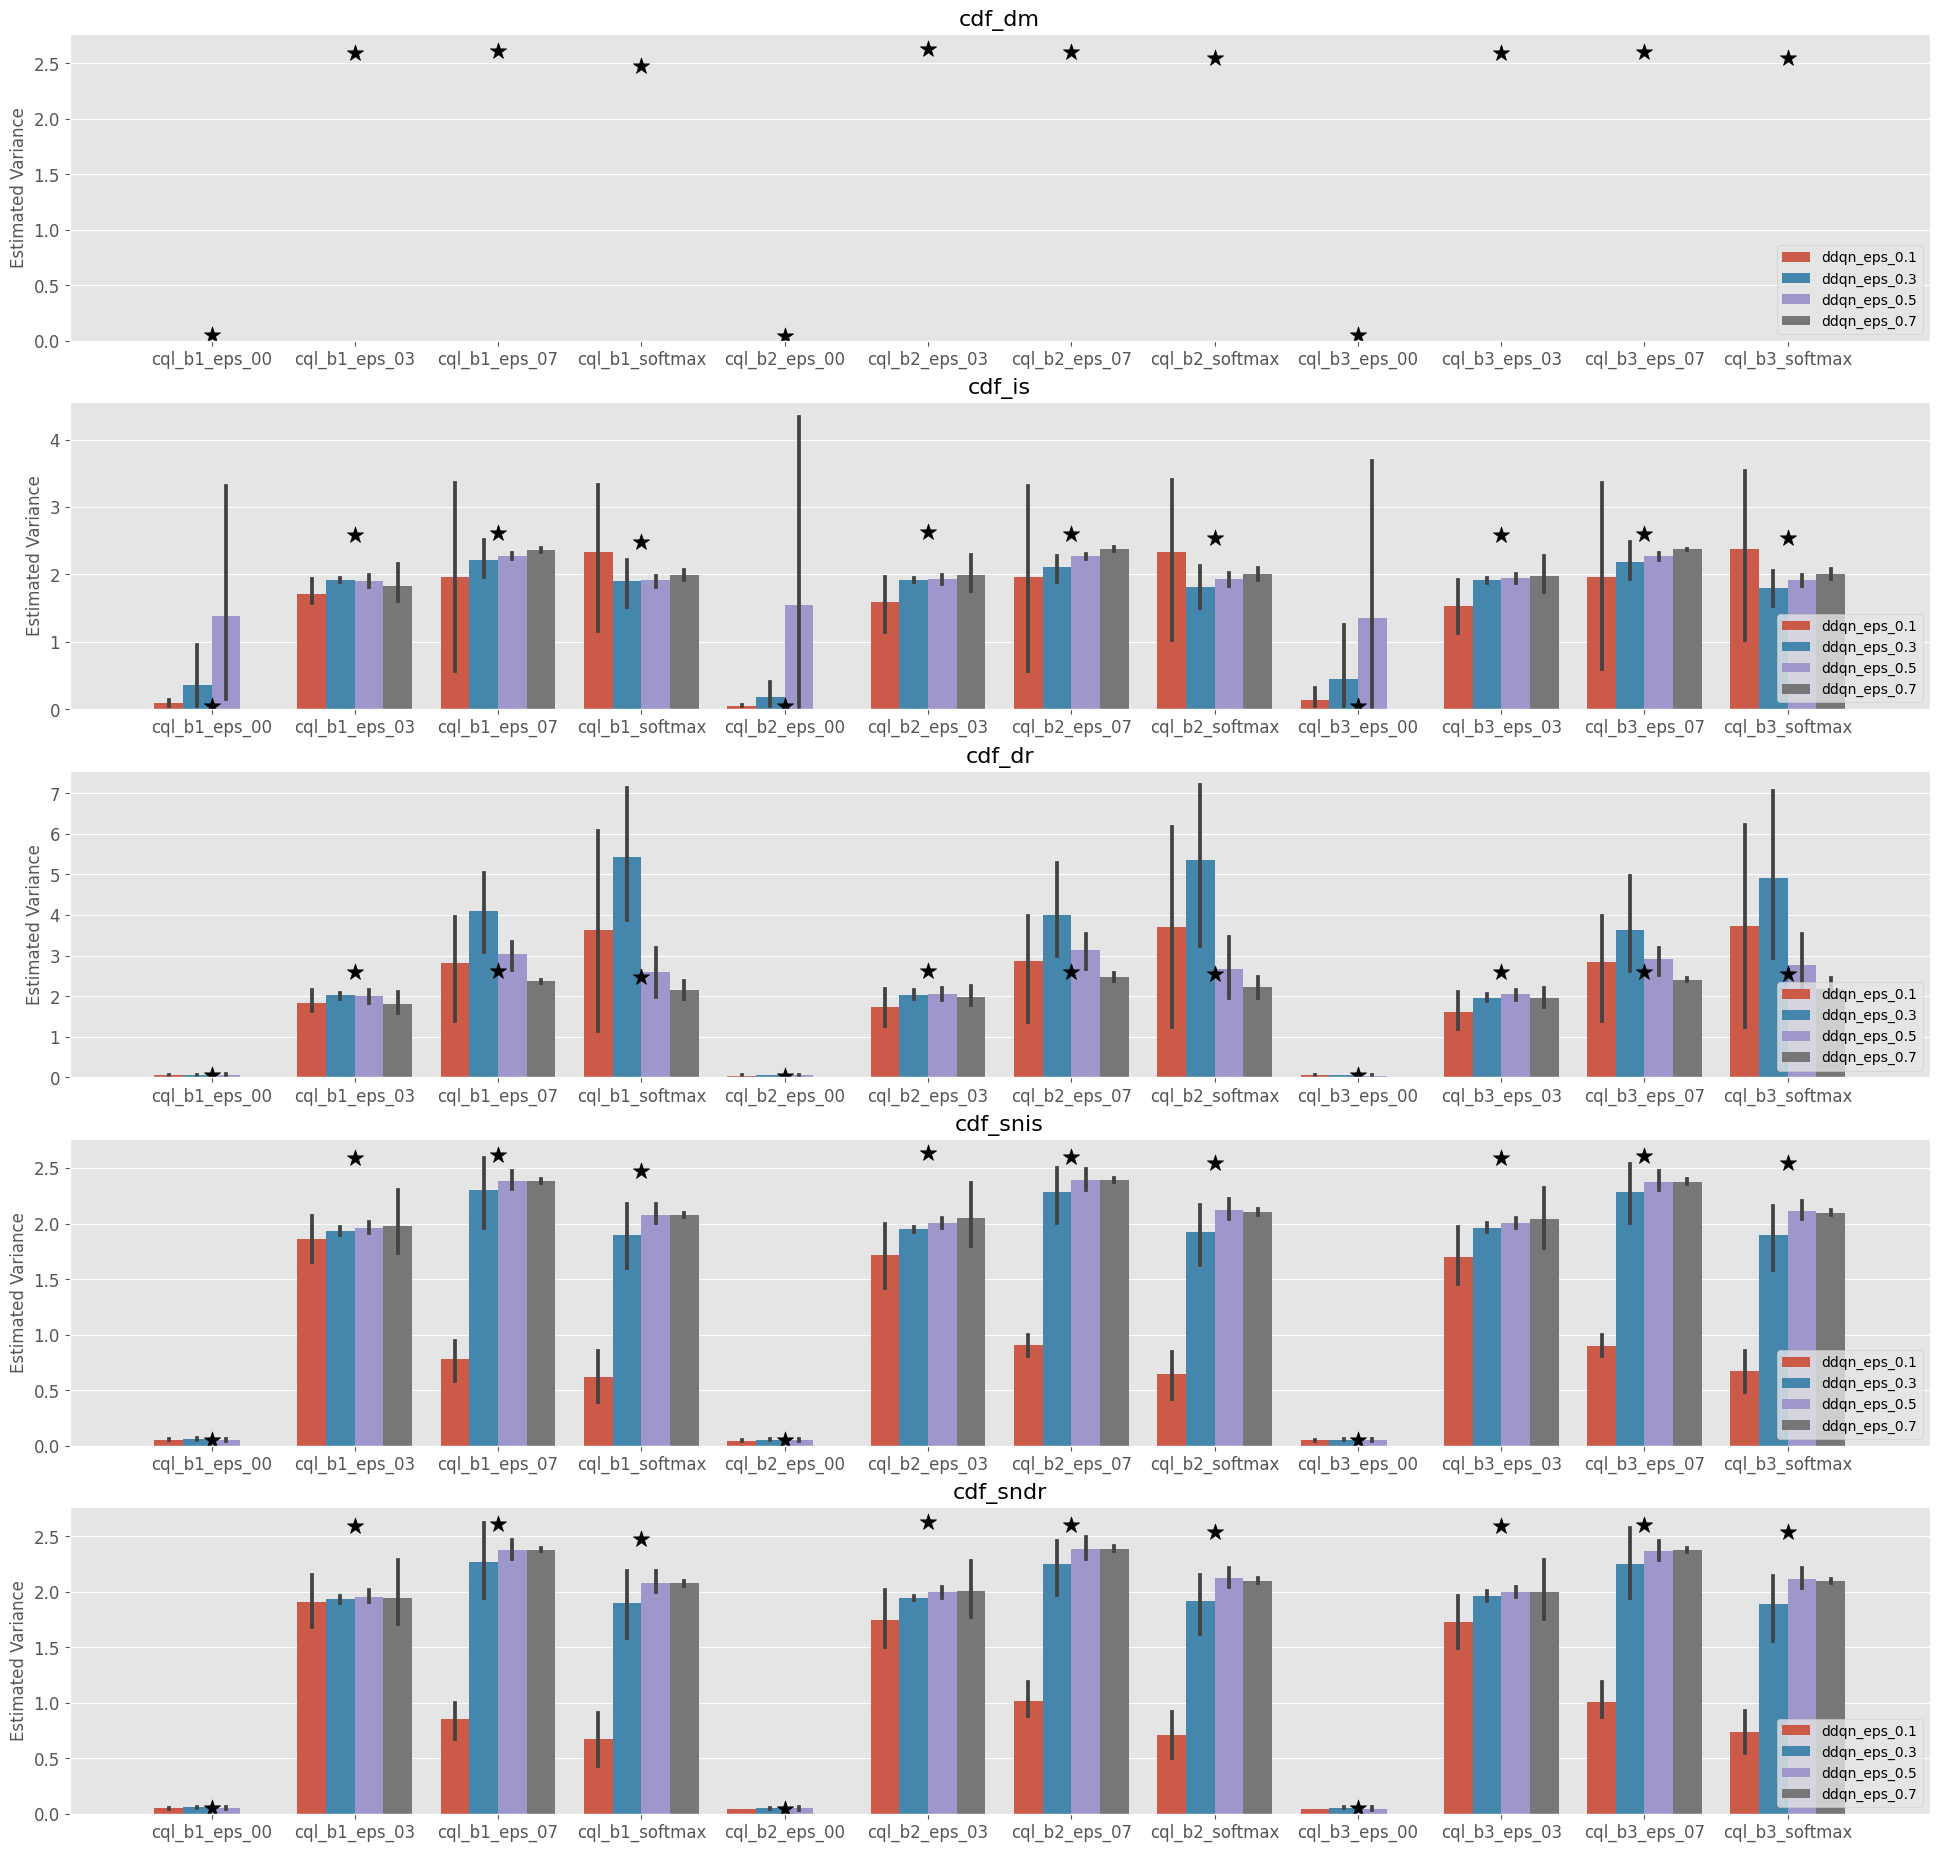

In [44]:
cd_ope.visualize_variance_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

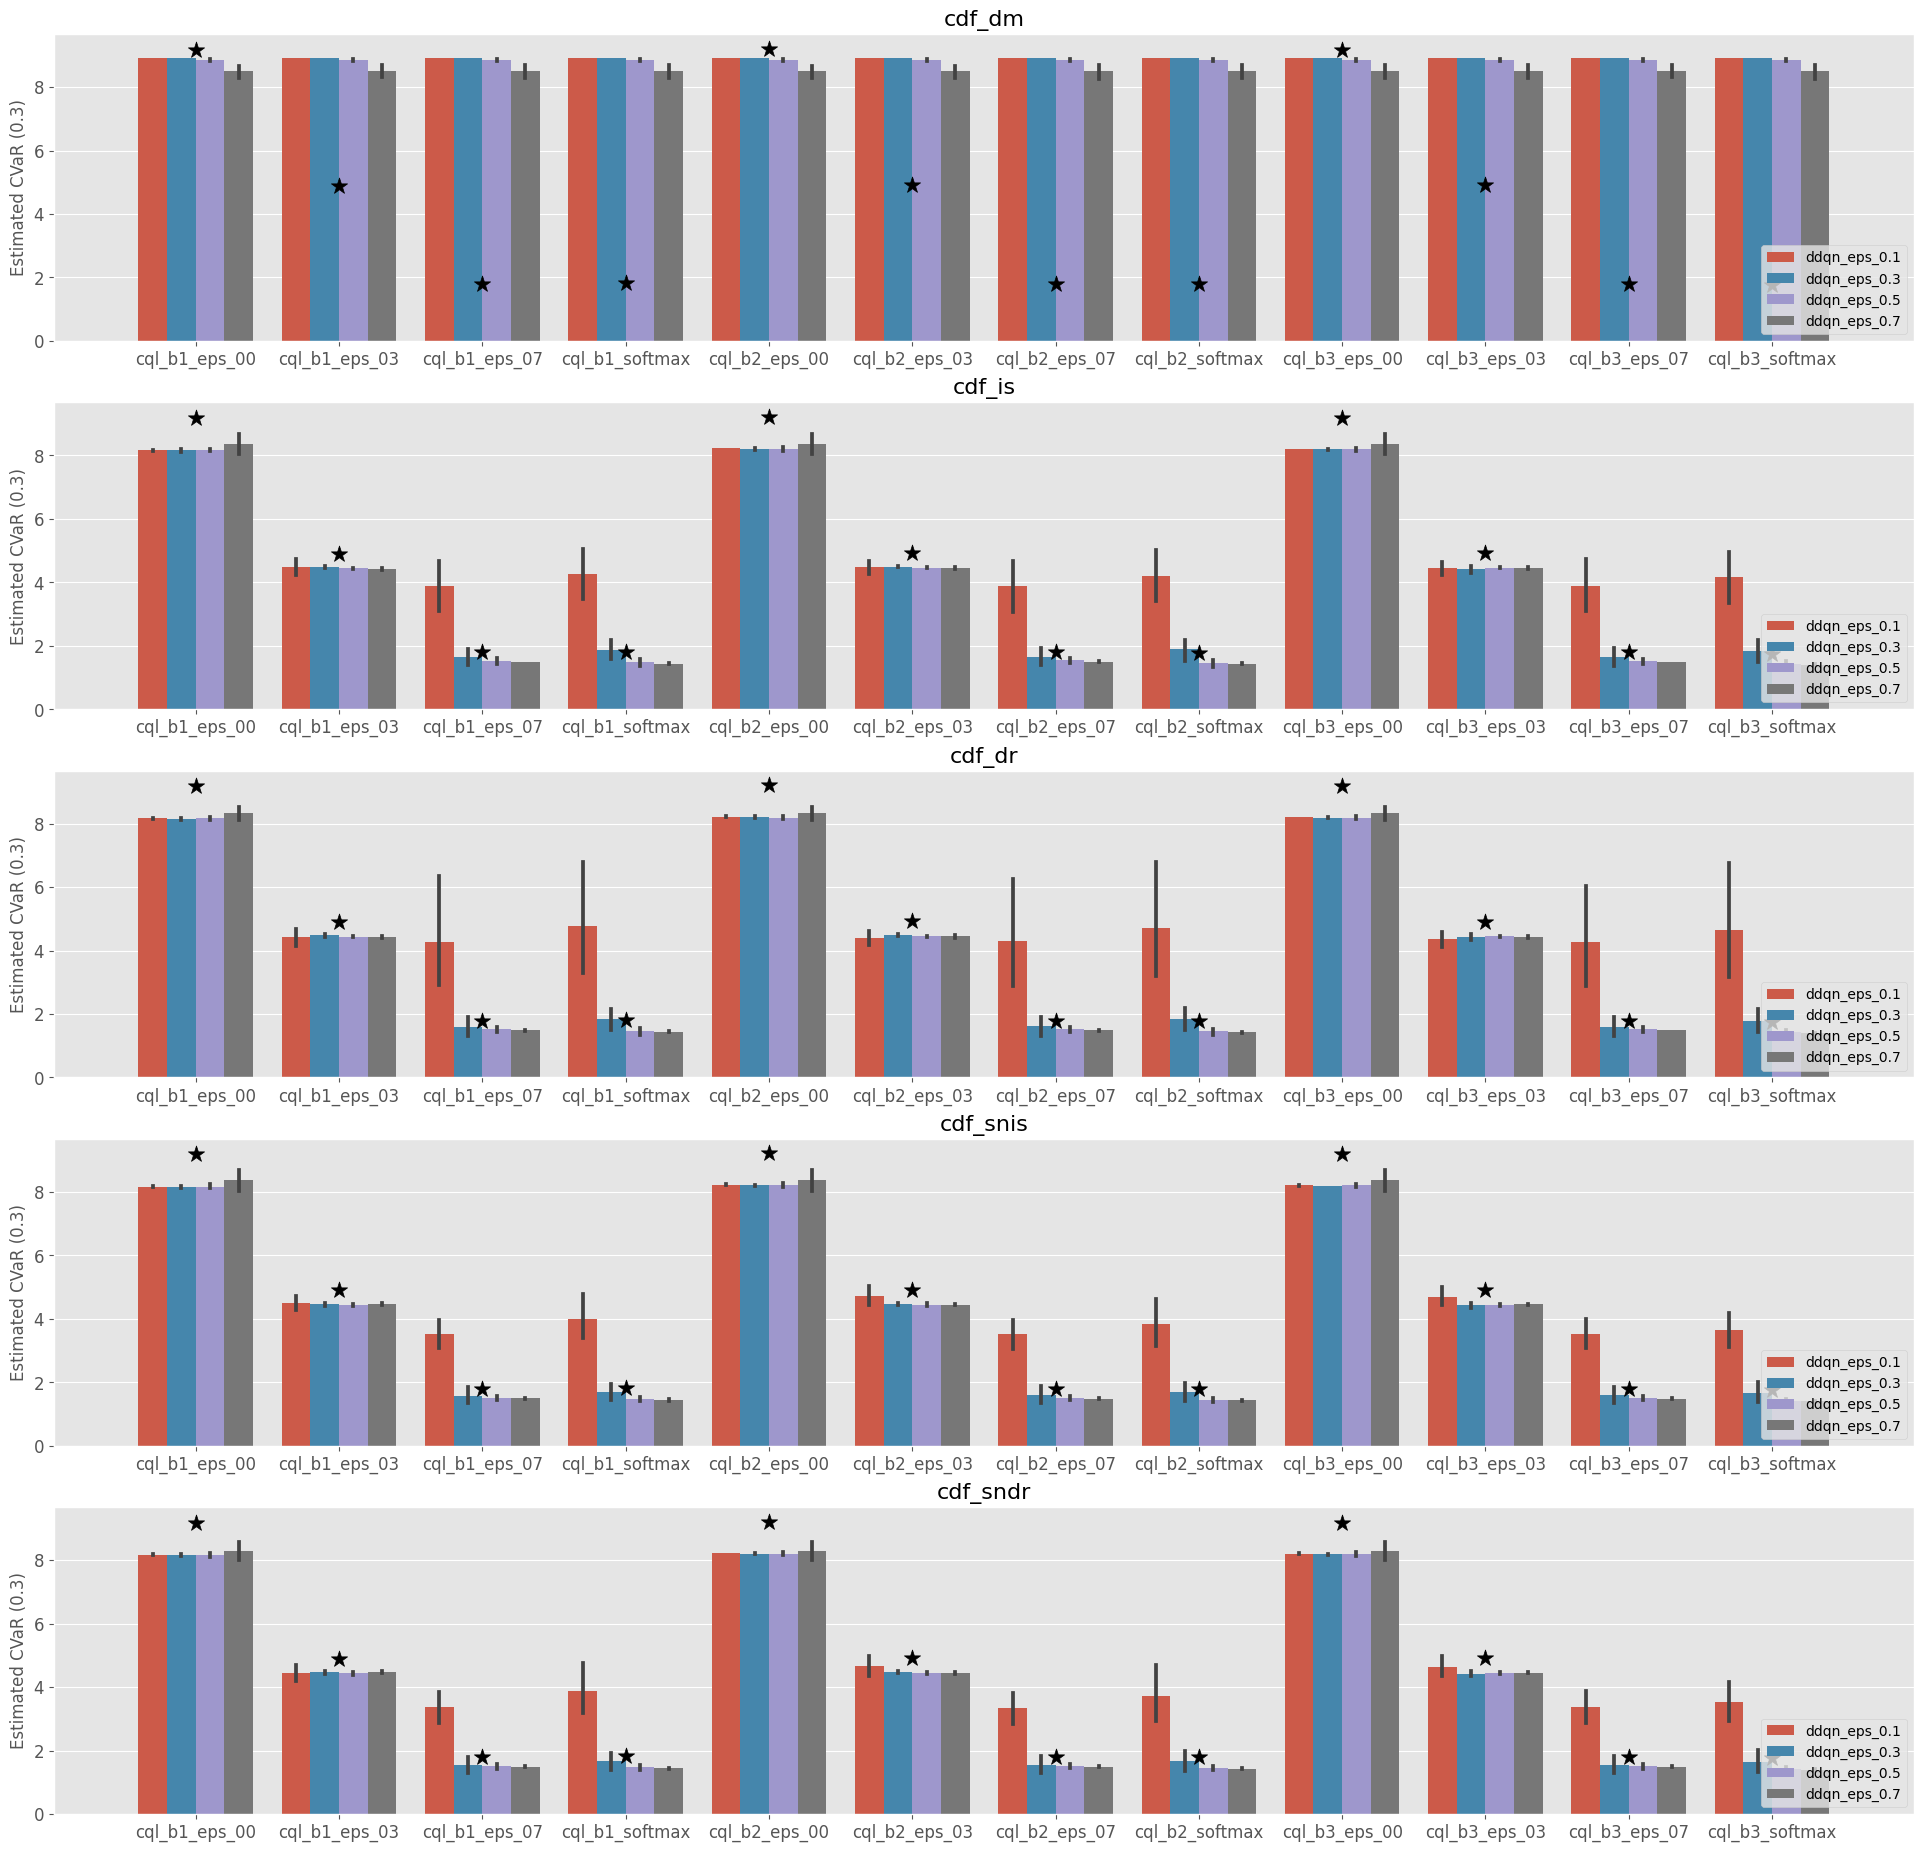

In [45]:
cd_ope.visualize_conditional_value_at_risk_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

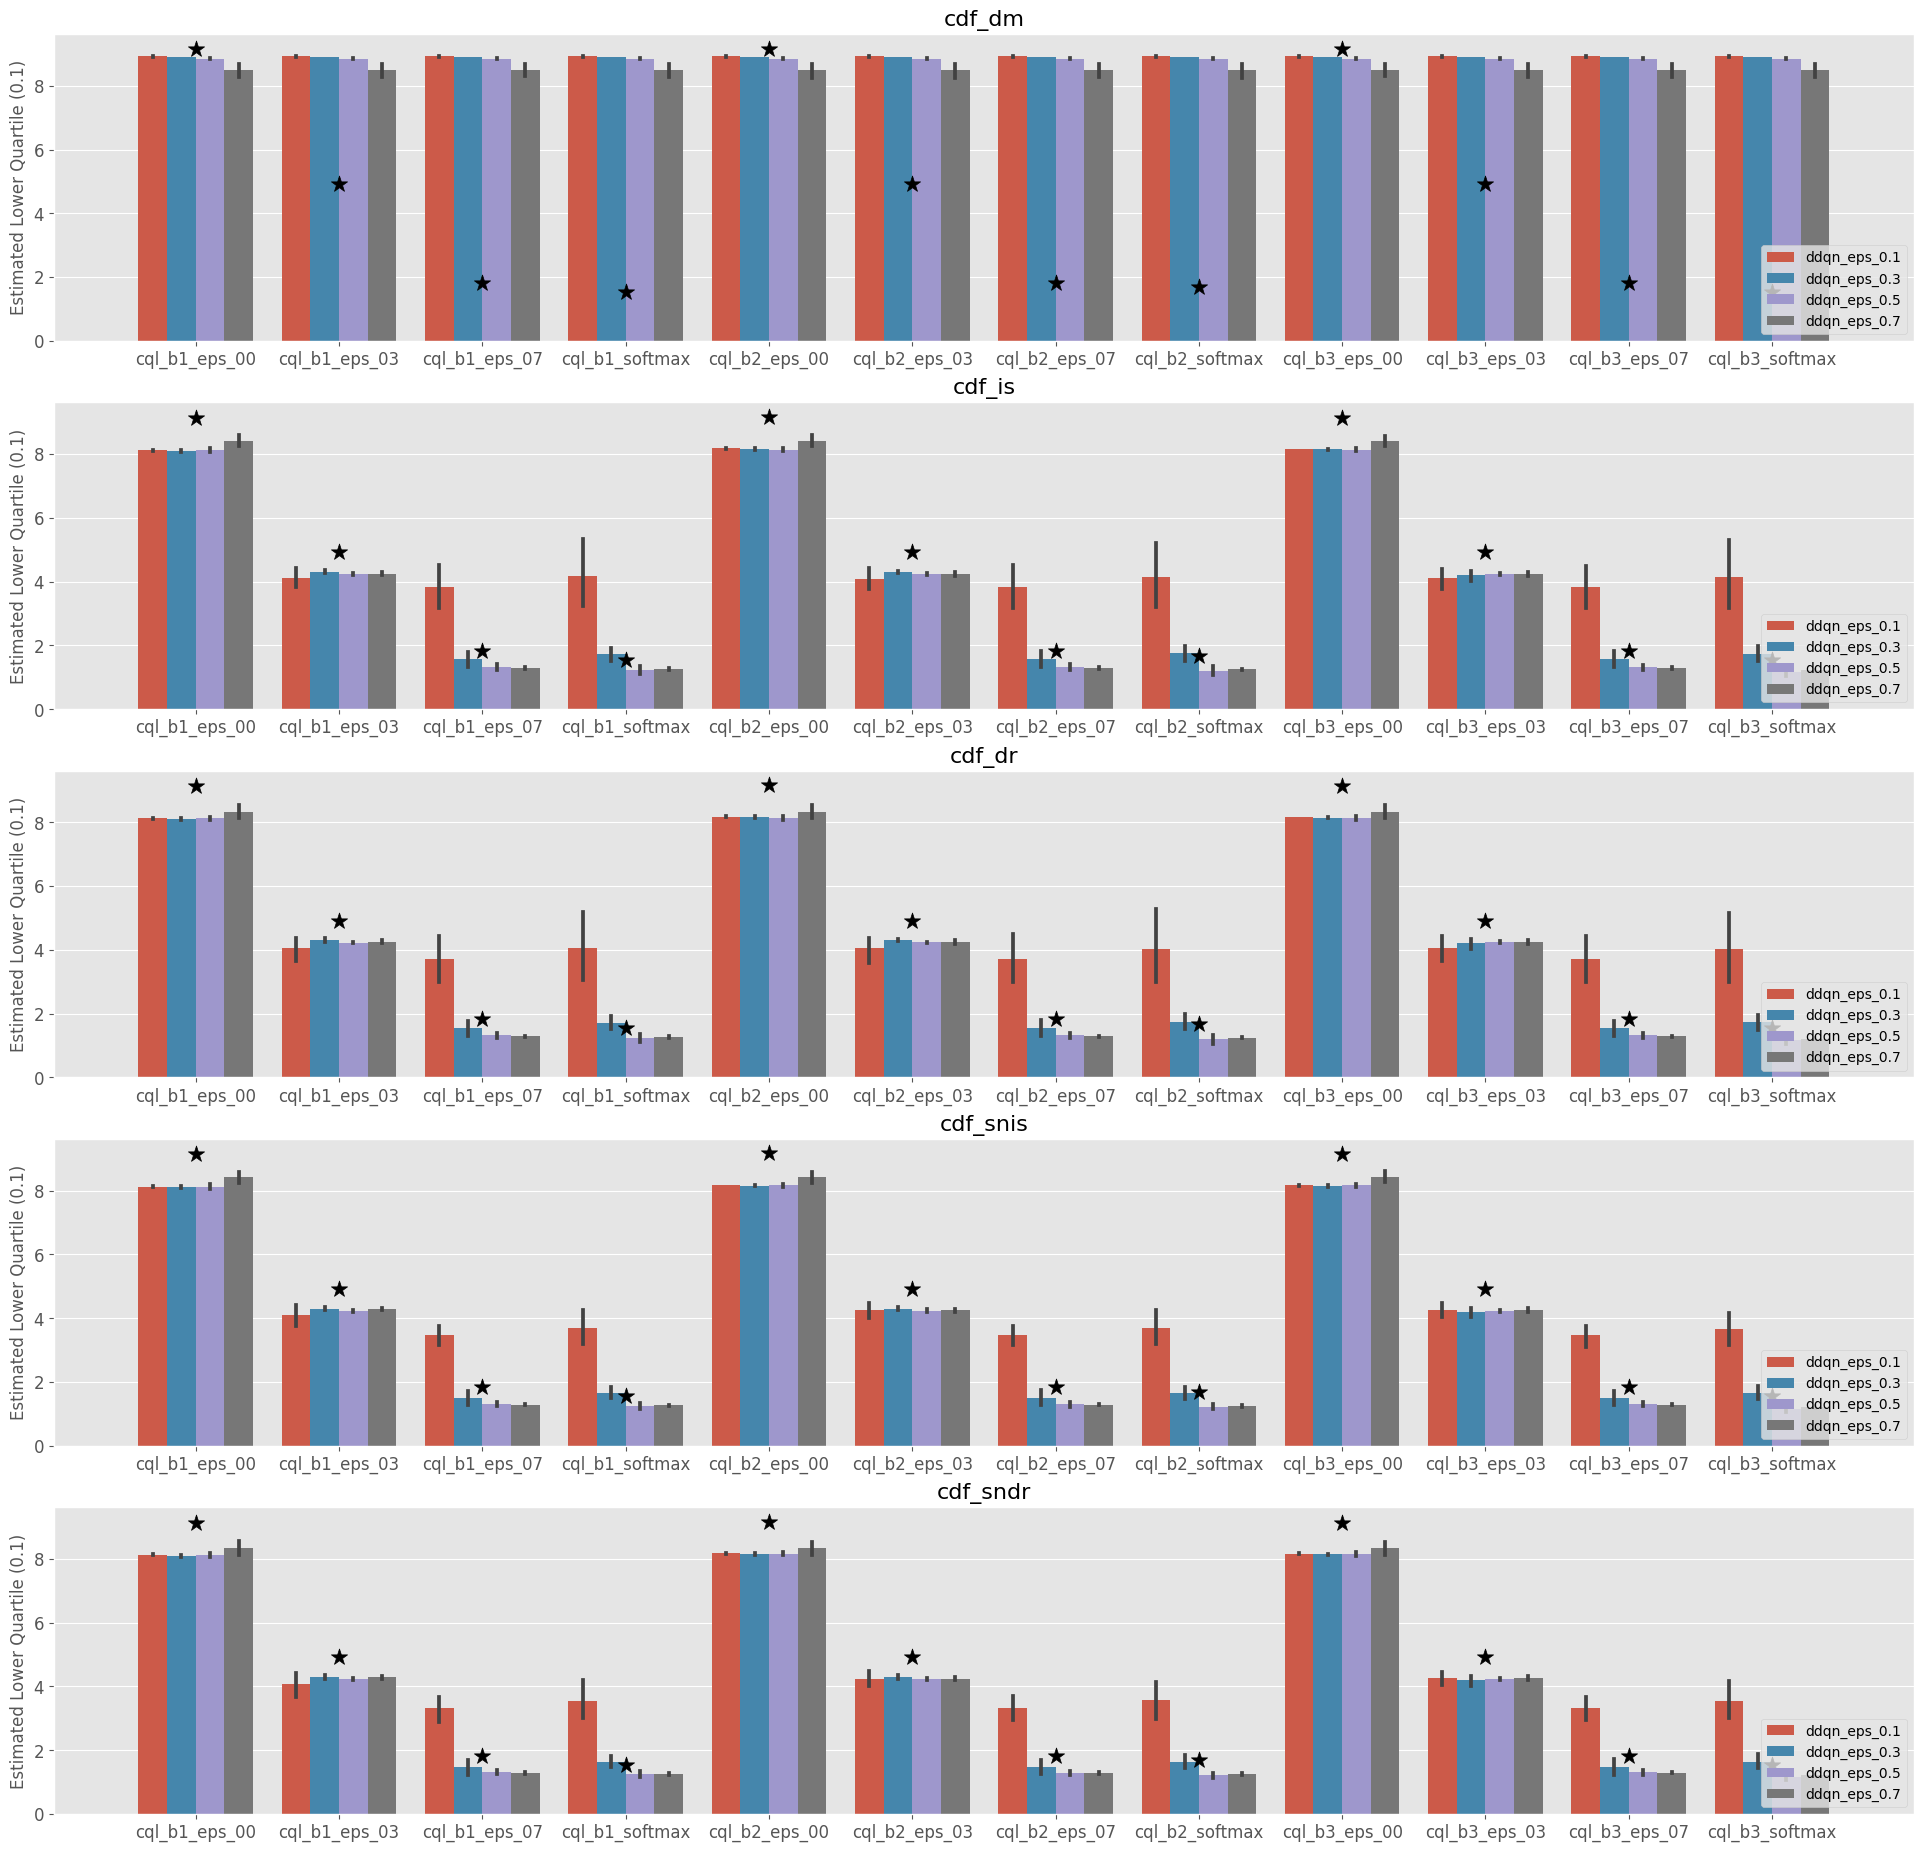

In [46]:
cd_ope.visualize_lower_quartile_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.1,
    plot_type="ci",
    hue="policy",
)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [47]:
from scope_rl.ope import OffPolicySelection

In [48]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [49]:
true_selection_result = ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)
true_selection_result["ddqn_eps_0.1"][0]

ranking  policy_value  relative_policy_value  variance  \
0    cql_b2_eps_00      9.478309               1.246049  0.048225   
1    cql_b3_eps_00      9.458224               1.243408  0.052994   
2    cql_b1_eps_00      9.455767               1.243085  0.052581   
3    cql_b2_eps_03      6.946372               0.913192  2.632563   
4    cql_b3_eps_03      6.930550               0.911112  2.591083   
5    cql_b1_eps_03      6.917596               0.909409  2.590969   
6    cql_b1_eps_07      3.672857               0.482846  2.615611   
7    cql_b3_eps_07      3.668719               0.482302  2.605670   
8    cql_b2_eps_07      3.664300               0.481721  2.602280   
9   cql_b1_softmax      3.640362               0.478574  2.477495   
10  cql_b2_softmax      3.619816               0.475873  2.544169   
11  cql_b3_softmax      3.616384               0.475422  2.544321   

   ranking_by_lower_quartile  lower_quartile  \
0              cql_b1_eps_00        9.114523   
1              cql_b1_eps_03        9.085010   
2              cql_b1_eps_07        9.085010   
3             cql_b1_softmax        4.313894   
4              cql_b2_eps_00        4.313894   
5              cql_b2_eps_03        4.283666   
6              cql_b2_eps_07        1.220731   
7             cql_b2_softmax        1.195876   
8              cql_b3_eps_00        1.195876   
9              cql_b3_eps_03        1.061498   
10             cql_b3_eps_07        1.061498   
11            cql_b3_softmax        1.061498   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                         cql_b2_eps_00                   9.069017  
1                         cql_b3_eps_00                   9.035166  
2                         cql_b1_eps_00                   9.035166  
3                         cql_b3_eps_03                   3.384531  
4                         cql_b2_eps_03                   3.384531  
5                         cql_b1_eps_03                   3.382683  
6                        cql_b2_softmax                   0.810936  
7                        cql_b1_softmax                   0.737201  
8                        cql_b3_softmax                   0.603130  
9                         cql_b3_eps_07                   0.203722  
10                        cql_b2_eps_07                   0.203722  
11                        cql_b1_eps_07                   0.203722

In [50]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [51]:
ranking_df["ddqn_eps_0.1"][0]

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0      cql_b3_eps_07               78.596940                        10.332606   
 1      cql_b2_eps_03               73.283287                         9.634056   
 2      cql_b2_eps_00               72.230072                         9.495597   
 3      cql_b1_eps_00               72.059687                         9.473198   
 4      cql_b1_eps_03               71.854367                         9.446206   
 5      cql_b3_eps_00               71.755669                         9.433230   
 6      cql_b1_eps_07               70.587064                         9.279602   
 7      cql_b3_eps_03               68.675498                         9.028301   
 8     cql_b3_softmax               68.563789                         9.013616   
 9      cql_b2_eps_07               66.992826                         8.807092   
 10    cql_b2_softmax               66.738255                         8.773625   
 11    cql

In [52]:
metric_df["ddqn_eps_0.1"][0]

estimator  mean_squared_error  rank_correlation        pvalue  regret@1  \
0        dm         4199.430018          0.657343  2.018550e-02  5.809590   
1       tis            1.795558          0.979021  3.089801e-08  0.020085   
2      pdis            0.856209          0.958042  9.543582e-07  0.000000   
3        dr          324.460860         -0.734266  6.543490e-03  5.861925   
4     sntis            0.424573          0.783217  2.586215e-03  0.000000   
5    snpdis            0.402366          0.965035  3.880985e-07  0.000000   
6      sndr            7.446621          0.916084  2.842805e-05  0.022543   

   type_i_error_rate  type_ii_error_rate  
0               0.00                 0.0  
1               0.00                 0.0  
2               0.00                 0.0  
3               0.00                 0.0  
4               0.00                 0.0  
5               0.00                 0.0  
6               0.25                 0.0

In [53]:
topk_metric_df = ops.obtain_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    return_safety_violation_rate=True,
    safety_threshold=14.0,
    return_by_dataframe=True,
)

In [54]:
topk_metric_df[:30]

estimator  topk      k-th      best     worst      mean       std  \
0         dm     0  6.706827  6.706827  6.706827  6.706827       NaN   
1         dm     1  6.378119  8.128621  4.956325  6.542473  2.243152   
2         dm     2  6.503353  8.509871  4.622129  6.529433  2.107555   
3         dm     3  7.121144  9.218844  4.289204  6.677360  2.332246   
4         dm     4  6.218732  9.472284  3.959442  6.585635  2.438190   
5         dm     5  6.290382  9.473288  3.788343  6.536426  2.444281   
6         dm     6  5.348269  9.475297  3.625727  6.366689  2.557968   
7         dm     7  5.671670  9.477305  3.620886  6.279812  2.541062   
8         dm     8  5.467400  9.477305  3.618098  6.189544  2.554317   
9         dm     9  5.632550  9.477305  3.617926  6.133845  2.569404   
10        dm    10  5.631108  9.478309  3.616728  6.088141  2.567275   
11        dm    11  4.099704  9.478309  3.616384  5.922438  2.554005   
0        tis     0  8.663502  8.663502  8.663502  8.663502       NaN   
1        tis     1  8.668098  8.673634  8.657966  8.665800  0.011079   
2        tis     2  8.665357  8.680024  8.656163  8.665652  0.012806   
3        tis     3  6.405211  8.806912  6.275686  8.100542  1.258756   
4        tis     4  6.403184  8.807035  6.267574  7.761070  1.379354   
5        tis     5  6.408284  8.808246  6.264541  7.535606  1.379102   
6        tis     6  3.819188  8.971131  3.653479  7.004689  2.029908   
7        tis     7  3.822033  8.971922  3.650376  6.606857  2.254735   
8        tis     8  3.944526  9.098519  3.647529  6.311042  2.371778   
9        tis     9  4.801717  9.475297  3.625291  6.160110  2.498334   
10       tis    10  4.802709  9.478309  3.617757  6.036710  2.549843   
11       tis    11  4.665449  9.478309  3.616384  5.922438  2.554005   
0       pdis     0  9.172496  9.172496  9.172496  9.172496       NaN   
1       pdis     1  9.170711  9.178378  9.164829  9.171604  0.009580   
2       pdis     2  9.047836  9.186412  9.038328  9.130348  0.084581   
3       pdis     3  6.766737  9.187830  6.764120  8.539445  1.214728   
4       pdis     4  6.768241  9.187830  6.756422  8.185204  1.319390   
5       pdis     5  6.895578  9.188037  6.752536  7.970266  1.319107   

    safety_violation_rate  sharpe_ratio  
0                     1.0           NaN  
1                     1.0      2.912928  
2                     1.0      3.447825  
3                     1.0      1.729171  
4                     1.0      1.687584  
5                     1.0      1.645772  
6                     1.0      1.582569  
7                     1.0      1.601398  
8                     1.0      1.593560  
9                     1.0      1.584849  
10                    1.0      1.581421  
11                    1.0      1.588825  
0                     1.0           NaN  
1                     1.0    561.708524  
2                     1.0    271.997867  
3                     1.0      2.732675  
4                     1.0      2.493684  
5                     1.0      2.495246  
6                     1.0      1.738046  
7                     1.0      1.586026  
8                     1.0      1.582058  
9                     1.0      1.652380  
10                    1.0      1.602073  
11                    1.0      1.588825  
0                     1.0           NaN  
1                     1.0   1052.508665  
2                     1.0    295.712718  
3                     1.0      3.095444  
4                     1.0      2.856002  
5                     1.0      2.857739

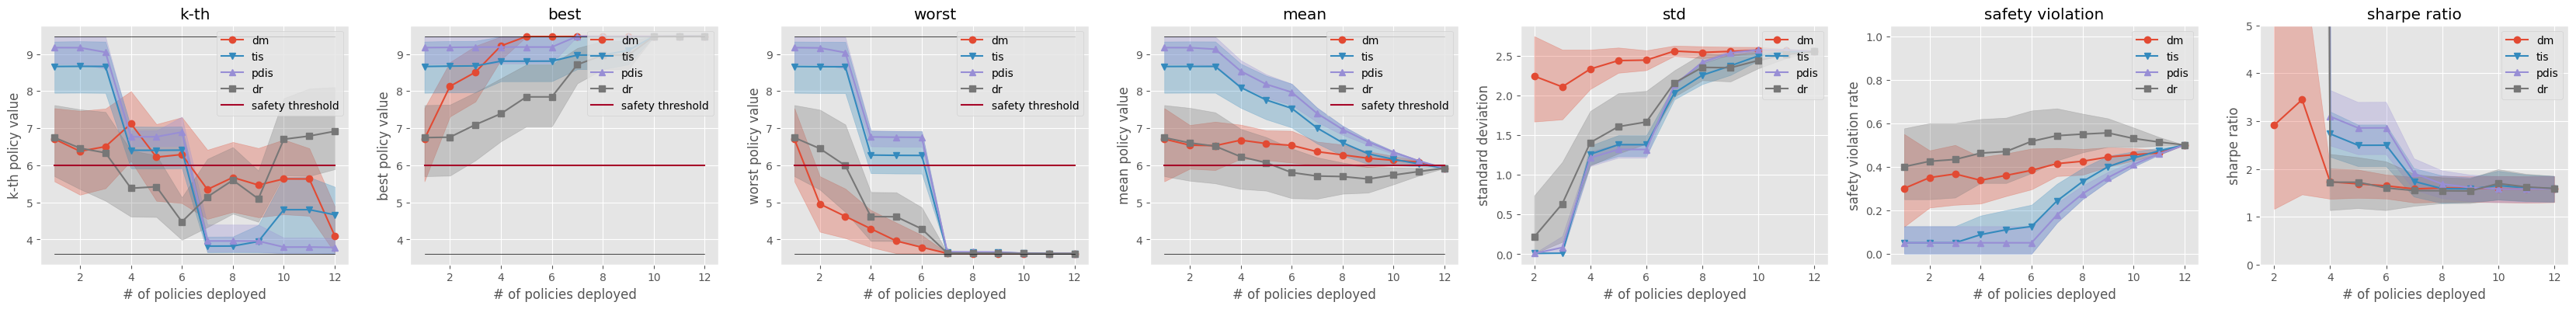

In [55]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    safety_threshold=6.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
    random_state=random_state,
)

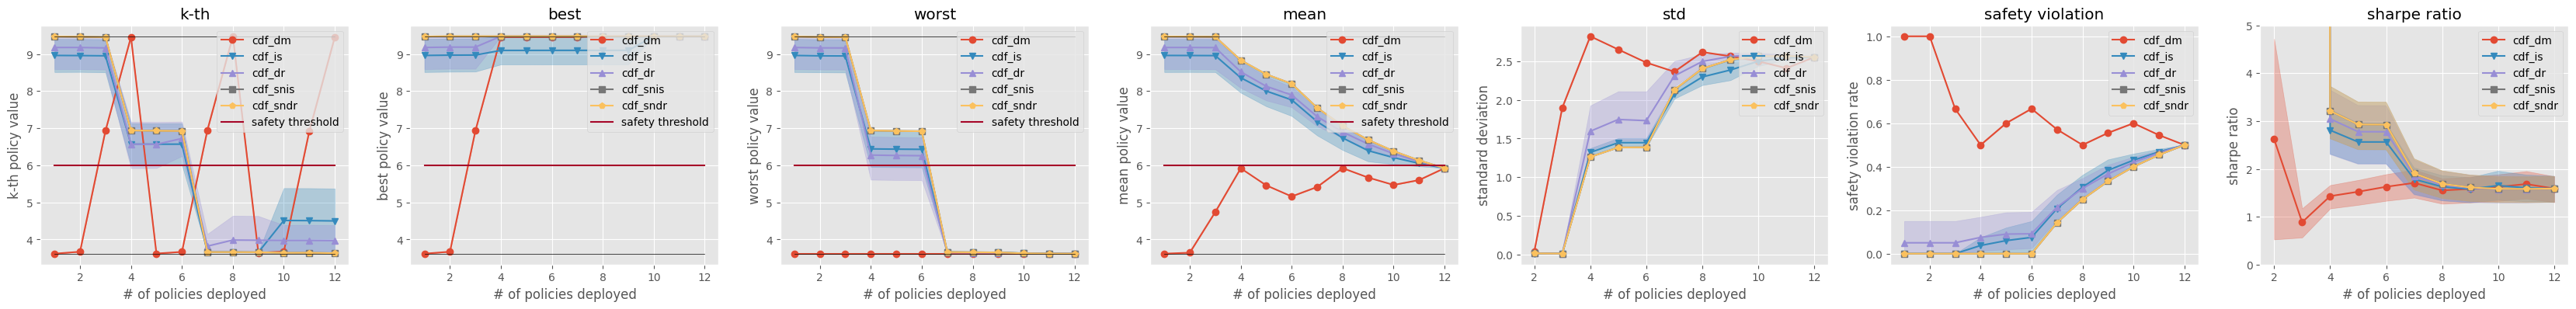

In [56]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    safety_threshold=6.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
    random_state=random_state,
)

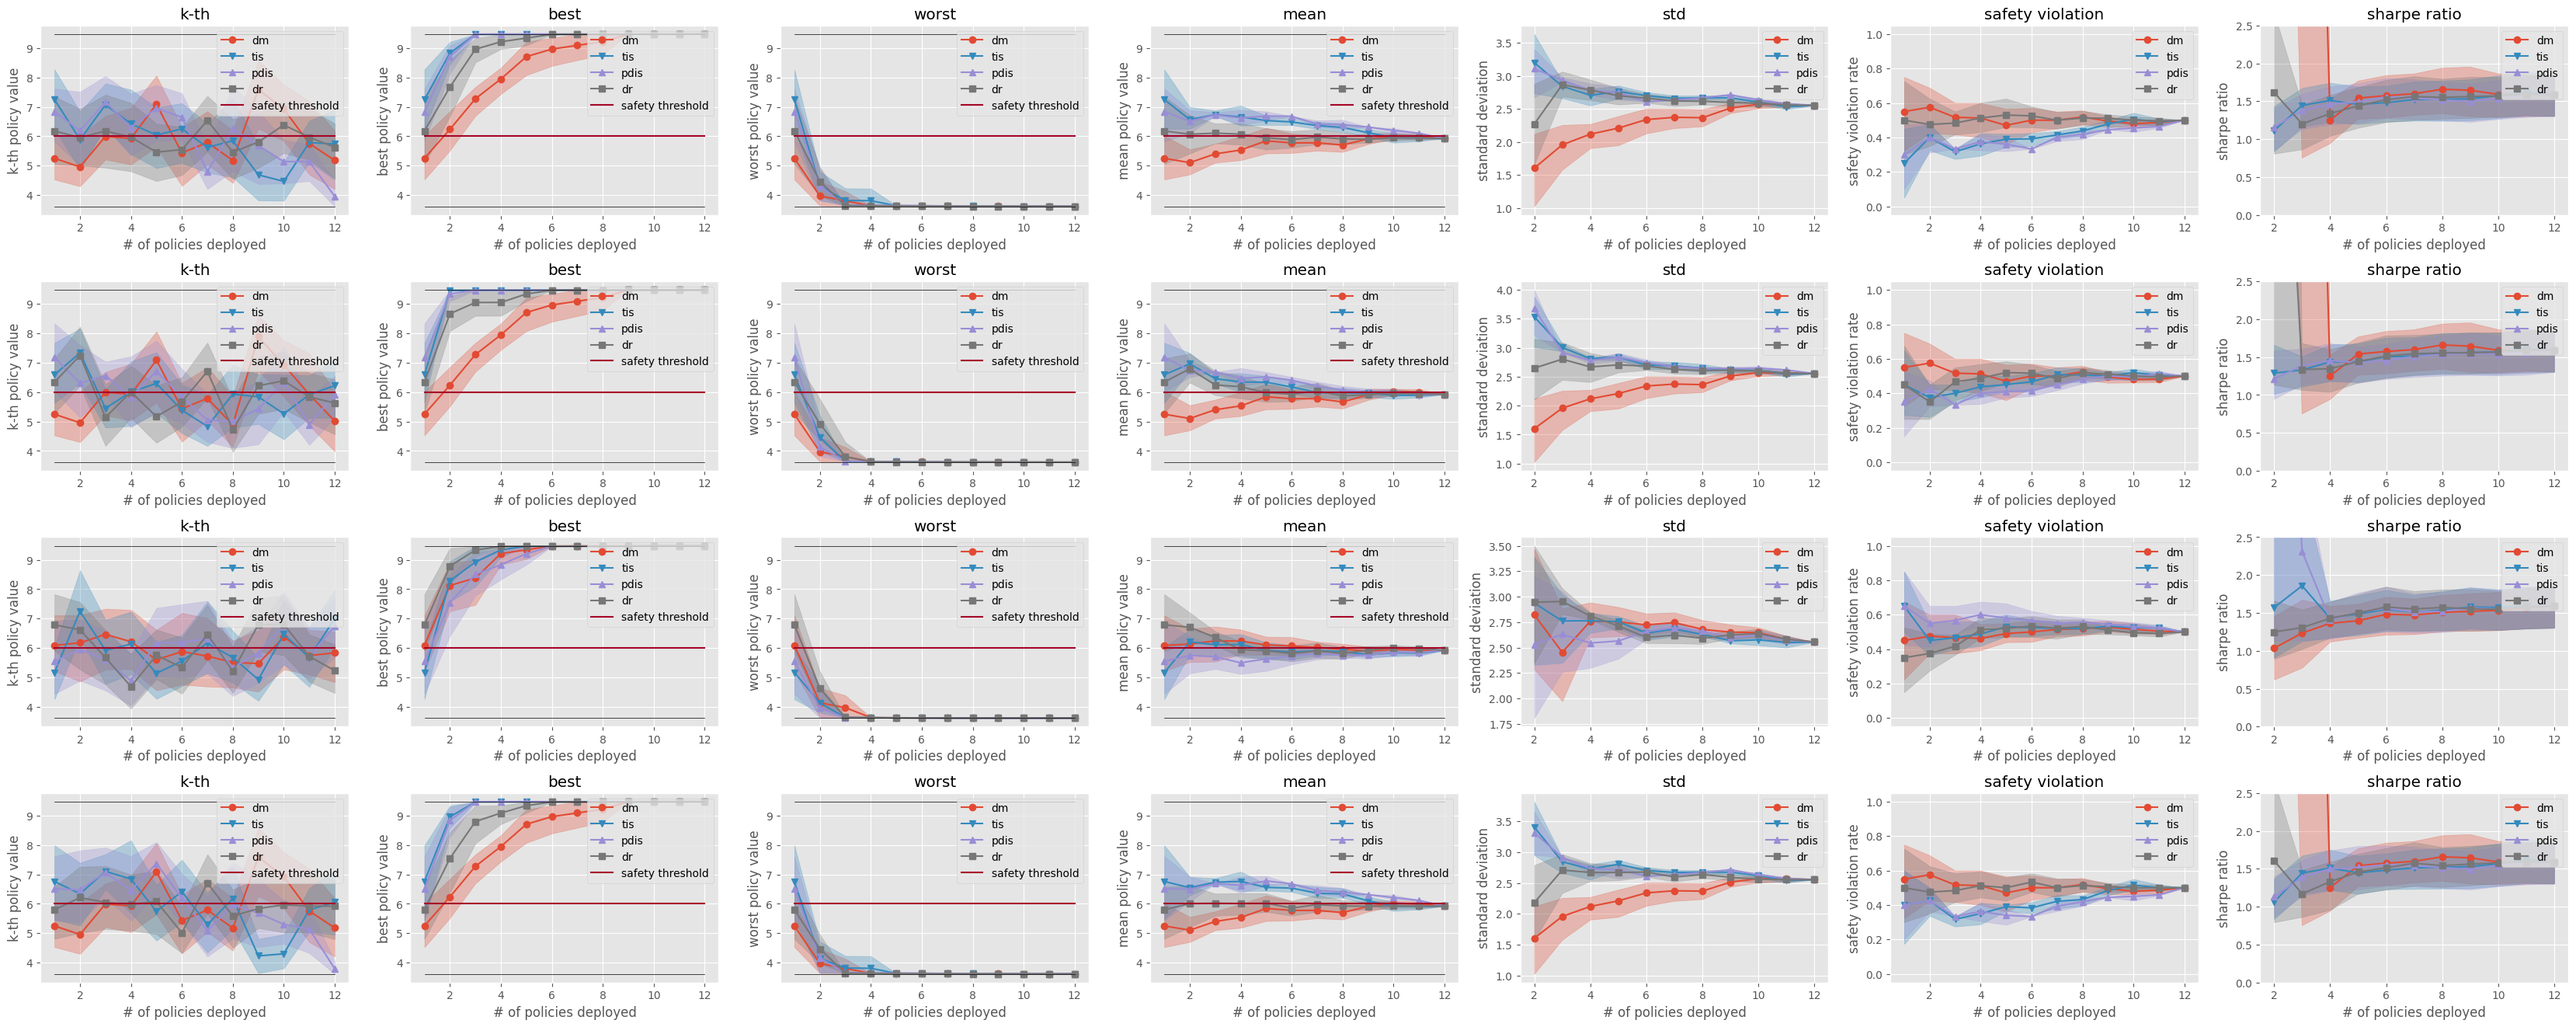

In [57]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    visualize_ci=True,
    safety_threshold=6.0,
    ymax_sharpe_ratio=2.5,
    legend=True,
    random_state=random_state,
)

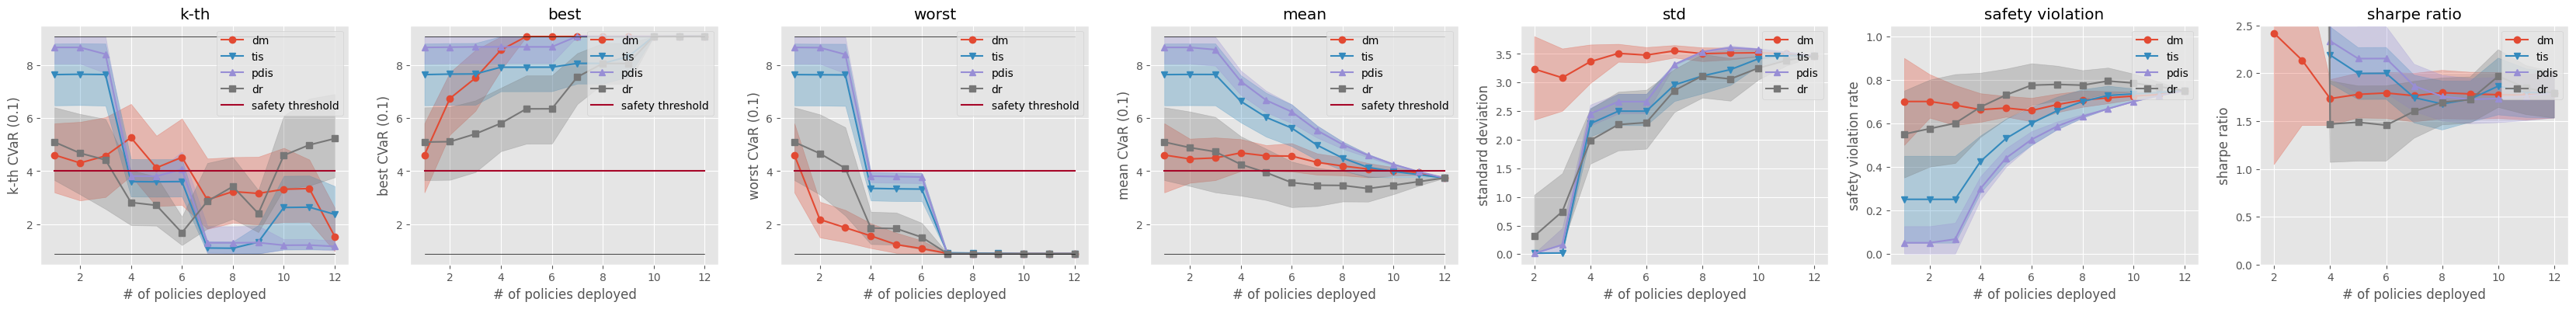

In [69]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=4.0,
    clip_sharpe_ratio=True,
    ymax_sharpe_ratio=2.5,
    legend=True,
    random_state=random_state,
)

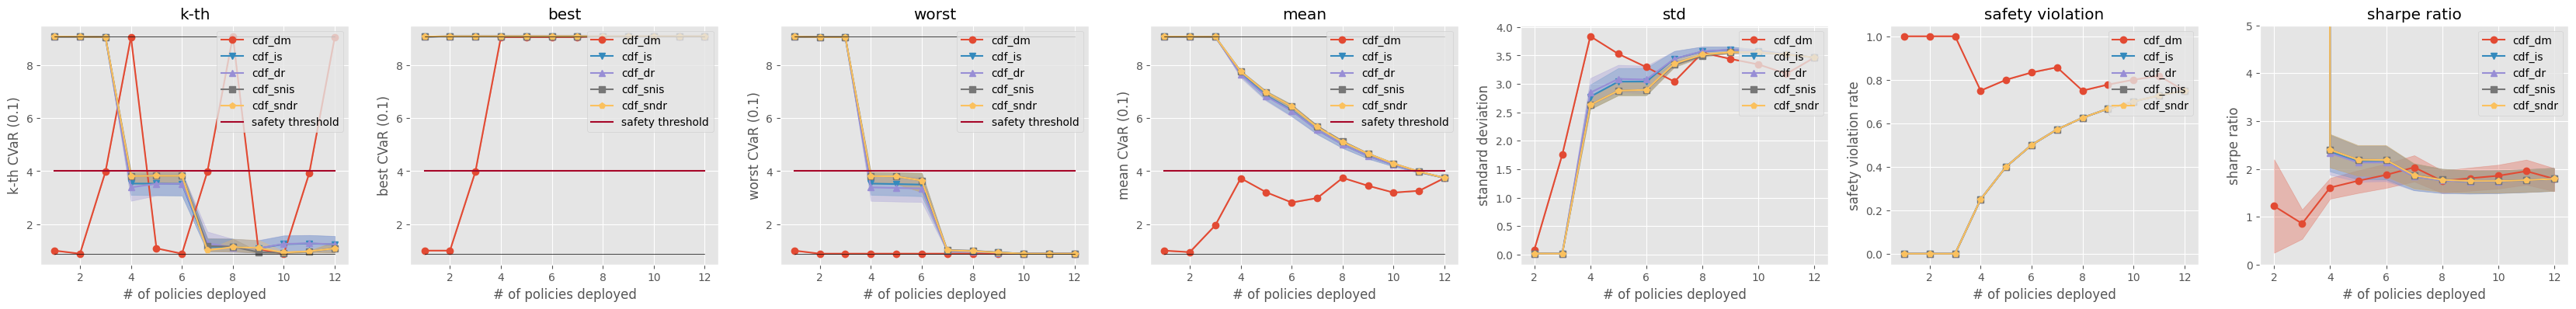

In [70]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=4.0,
    ymax_sharpe_ratio=5.0,
    legend=True,
    random_state=random_state,
)

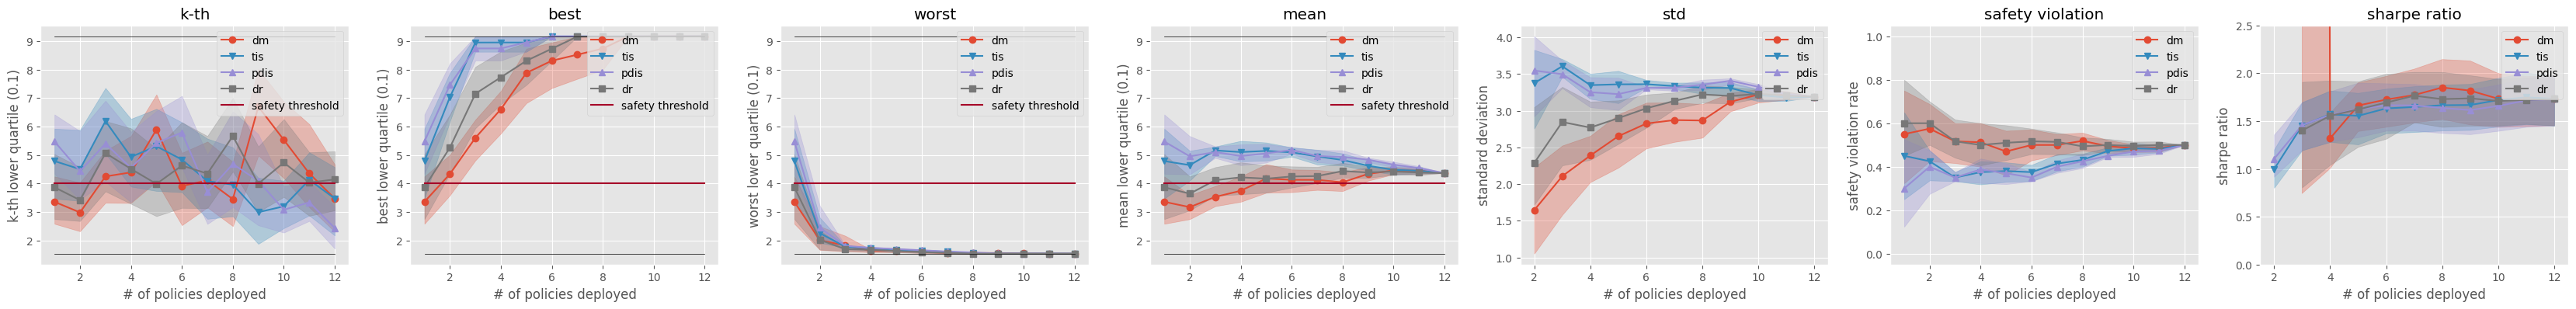

In [60]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=4.0,
    ymax_sharpe_ratio=2.5,
    legend=True,
    random_state=random_state,
)

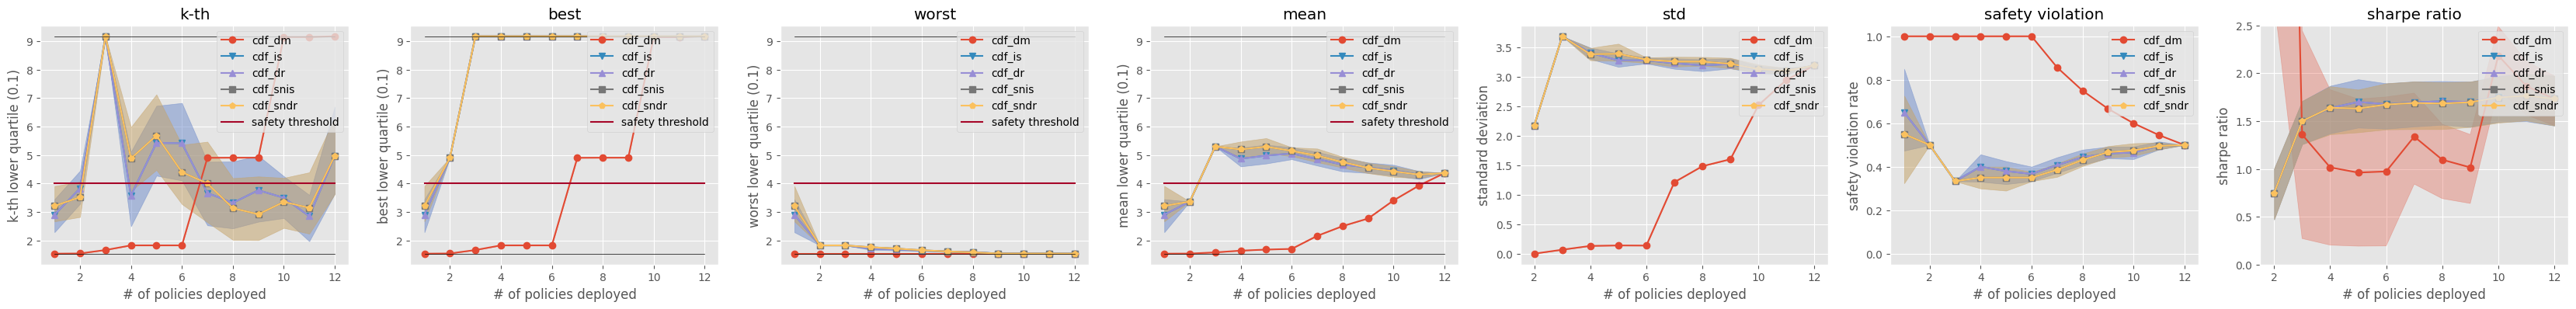

In [61]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=4.0,
    ymax_sharpe_ratio=2.5,
    legend=True,
    random_state=random_state,
)

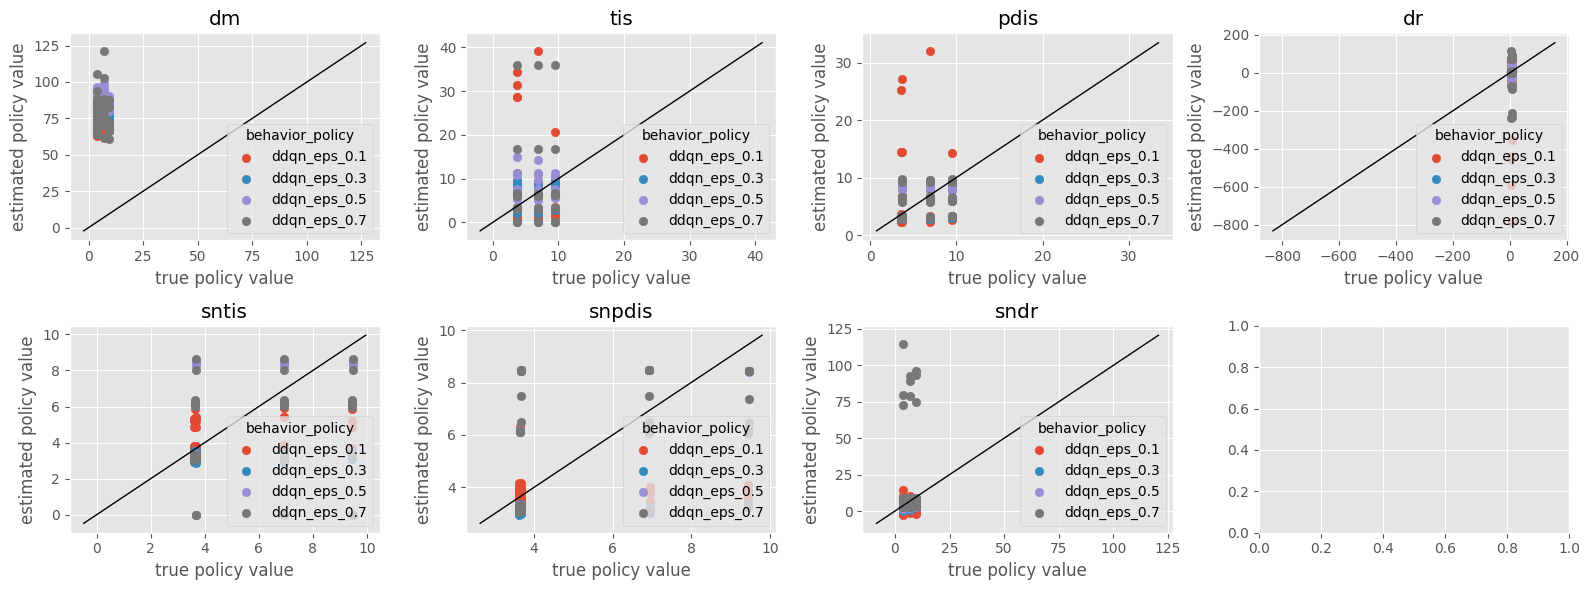

In [68]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
)

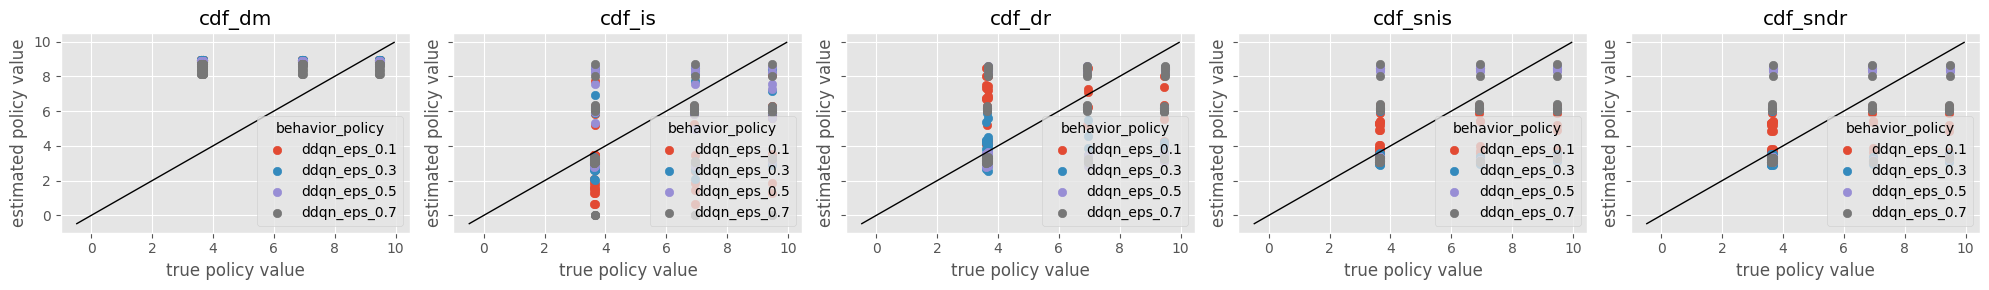

In [63]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

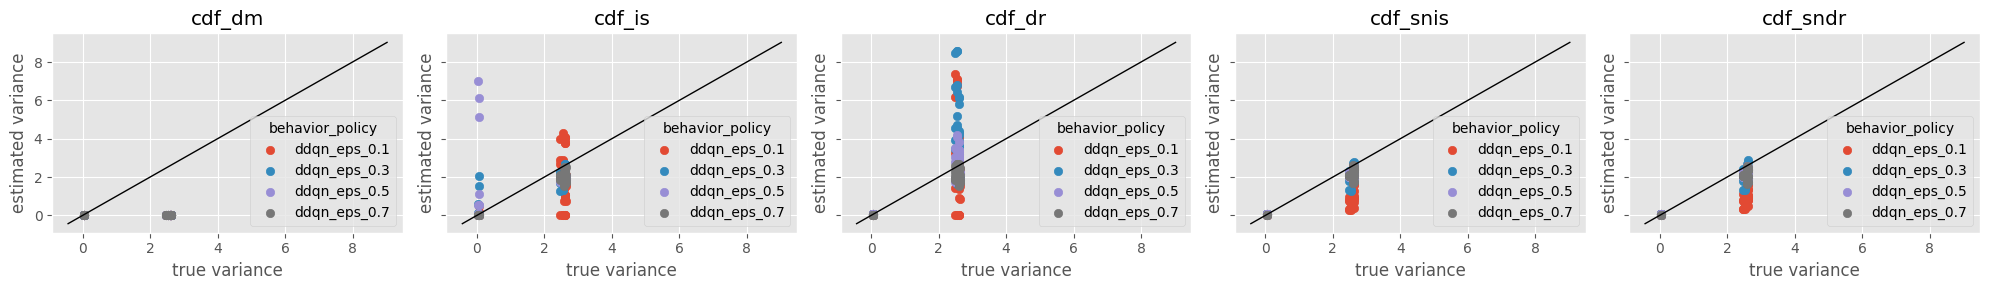

In [65]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

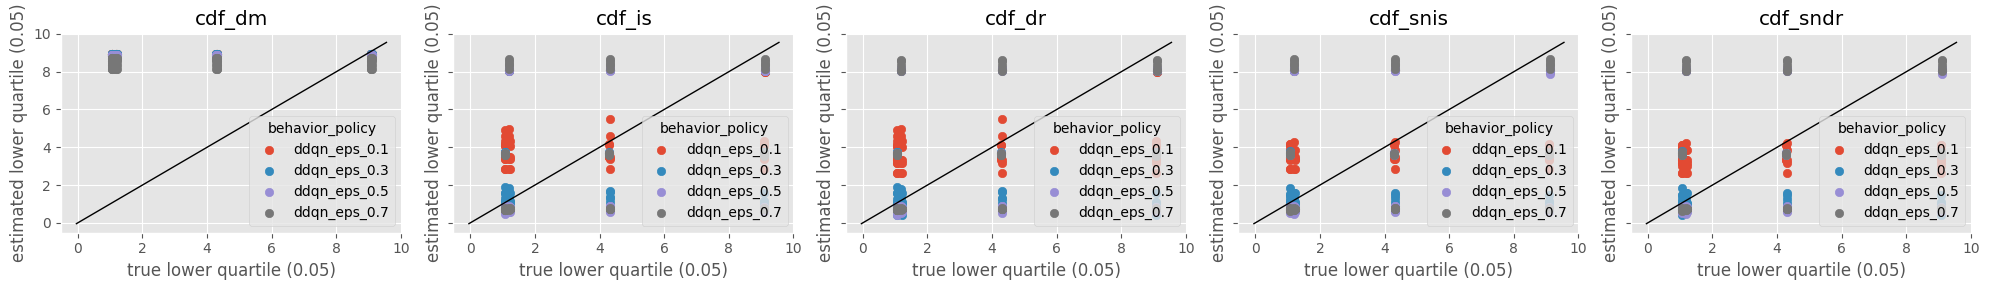

In [66]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

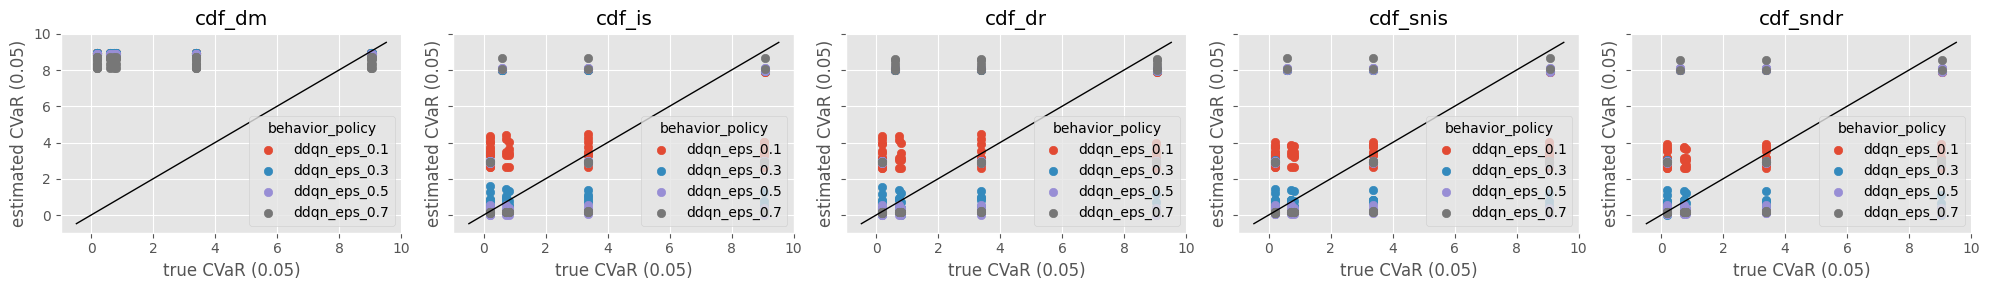

In [67]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

For the examples in the continuous action space, please refer to [examples/quickstart/basic/basic_synthetic_continuous_multiple_datasets.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/basic/basic_synthetic_continuous_multiple_datasets.ipynb).

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.